<a href="https://colab.research.google.com/github/hikaru122700/signate_apple/blob/main/01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**このコードはTremendous1192さんの以下の記事を参考にして作成されました。**


**この場を借りて感謝をしたいと思います。**


https://zenn.dev/tremendous1192/articles/ea6e73359ee764

In [4]:
!pip install polars
!pip install japanize_matplotlib
!pip install jpholiday
!pip install prophet
!pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=59ed24181bcdb64909c550d4543775e8e17441582267eb25c8a89b78a1d82de2
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00


In [5]:
import polars as pl# DataFrame
import polars.selectors as cs# polarsのサブモジュール
pl.Config.set_fmt_str_lengths(100)# print, displayの表示制限調整
import numpy as np# 数値計算

import matplotlib.pyplot as plt# グラフ
import japanize_matplotlib# 日本語ラベル
import seaborn as sns# グラフ
%matplotlib inline

from datetime import date# 日時
import matplotlib.dates as mdates# グラフの日時調整

import jpholiday# 休日

from prophet import Prophet# 時系列分析

from sklearn.metrics import mean_absolute_error, make_scorer, r2_score# 評価関数
from sklearn.ensemble import GradientBoostingRegressor# 推定器
from sklearn.model_selection import RepeatedKFold# 交差検証
from sklearn.experimental import enable_halving_search_cv# ハイパーパラメータ最適化
from sklearn.model_selection import HalvingRandomSearchCV# ハイパーパラメータ最適化

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path  = "/content/drive/My Drive/signate/アップル/"

In [8]:
train = pl.read_csv(f"{path}train.csv")
test = pl.read_csv(f"{path}test.csv")
sample_submit = pl.read_csv(f"{path}sample_submit.csv", has_header = False)

In [9]:
train

datetime,y,client,close,price_am,price_pm
str,i64,i64,i64,i64,i64
"""2010-07-01""",17,0,0,-1,-1
"""2010-07-02""",18,0,0,-1,-1
"""2010-07-03""",20,0,0,-1,-1
"""2010-07-04""",20,0,0,-1,-1
"""2010-07-05""",14,0,0,-1,-1
…,…,…,…,…,…
"""2016-03-27""",94,1,0,5,4
"""2016-03-28""",86,1,0,4,4
"""2016-03-29""",98,1,0,4,4


In [10]:
test

datetime,client,close,price_am,price_pm
str,i64,i64,i64,i64
"""2016-04-01""",1,0,3,2
"""2016-04-02""",0,0,5,5
"""2016-04-03""",1,0,2,2
"""2016-04-04""",1,0,1,1
"""2016-04-05""",0,0,1,1
…,…,…,…,…
"""2017-03-27""",0,0,5,4
"""2017-03-28""",0,0,4,4
"""2017-03-29""",0,0,3,3


In [11]:
print("train:", train.shape, " test:", test.shape, " sample_submit:", sample_submit.shape)

train: (2101, 6)  test: (365, 5)  sample_submit: (365, 2)


In [12]:
print("train\n", train.head(), "\ntest\n", test.head(), "\nsample_submit\n", sample_submit.head())

train
 shape: (5, 6)
┌────────────┬─────┬────────┬───────┬──────────┬──────────┐
│ datetime   ┆ y   ┆ client ┆ close ┆ price_am ┆ price_pm │
│ ---        ┆ --- ┆ ---    ┆ ---   ┆ ---      ┆ ---      │
│ str        ┆ i64 ┆ i64    ┆ i64   ┆ i64      ┆ i64      │
╞════════════╪═════╪════════╪═══════╪══════════╪══════════╡
│ 2010-07-01 ┆ 17  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-02 ┆ 18  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-03 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-04 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-05 ┆ 14  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
└────────────┴─────┴────────┴───────┴──────────┴──────────┘ 
test
 shape: (5, 5)
┌────────────┬────────┬───────┬──────────┬──────────┐
│ datetime   ┆ client ┆ close ┆ price_am ┆ price_pm │
│ ---        ┆ ---    ┆ ---   ┆ ---      ┆ ---      │
│ str        ┆ i64    ┆ i64   ┆ i64      ┆ i64      │
╞════════════╪════════╪═══════╪══════════╪══════════╡
│ 2016-04-01 ┆ 1      ┆ 0   

In [13]:
train = train.insert_column(0, train["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))
test = test.insert_column(0, test["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))

print(train.head())

shape: (5, 7)
┌────────────┬────────────┬─────┬────────┬───────┬──────────┬──────────┐
│ id         ┆ datetime   ┆ y   ┆ client ┆ close ┆ price_am ┆ price_pm │
│ ---        ┆ ---        ┆ --- ┆ ---    ┆ ---   ┆ ---      ┆ ---      │
│ str        ┆ date       ┆ i64 ┆ i64    ┆ i64   ┆ i64      ┆ i64      │
╞════════════╪════════════╪═════╪════════╪═══════╪══════════╪══════════╡
│ 2010-07-01 ┆ 2010-07-01 ┆ 17  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-02 ┆ 2010-07-02 ┆ 18  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-03 ┆ 2010-07-03 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-04 ┆ 2010-07-04 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-05 ┆ 2010-07-05 ┆ 14  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
└────────────┴────────────┴─────┴────────┴───────┴──────────┴──────────┘


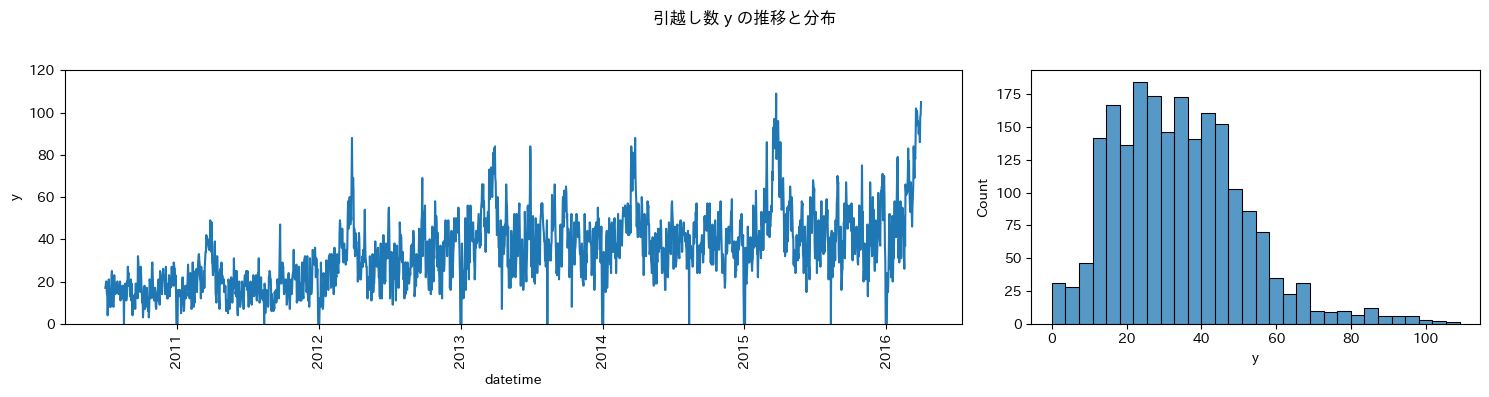

In [14]:
fig, axes = plt.subplots(
    nrows = 1, ncols = 2, # axの縦・横の数
    height_ratios = [1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 4)
)

# 描画
g_time = sns.lineplot(data = train, x = "datetime", y = "y", ax = axes[0])
g_hist = sns.histplot(data = train, x = "y", ax = axes[1])

# 調整
plt.setp(g_time.get_xticklabels(), rotation = 90)
plt.setp(g_time, ylim = (0, 120))

plt.suptitle("引越し数 y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

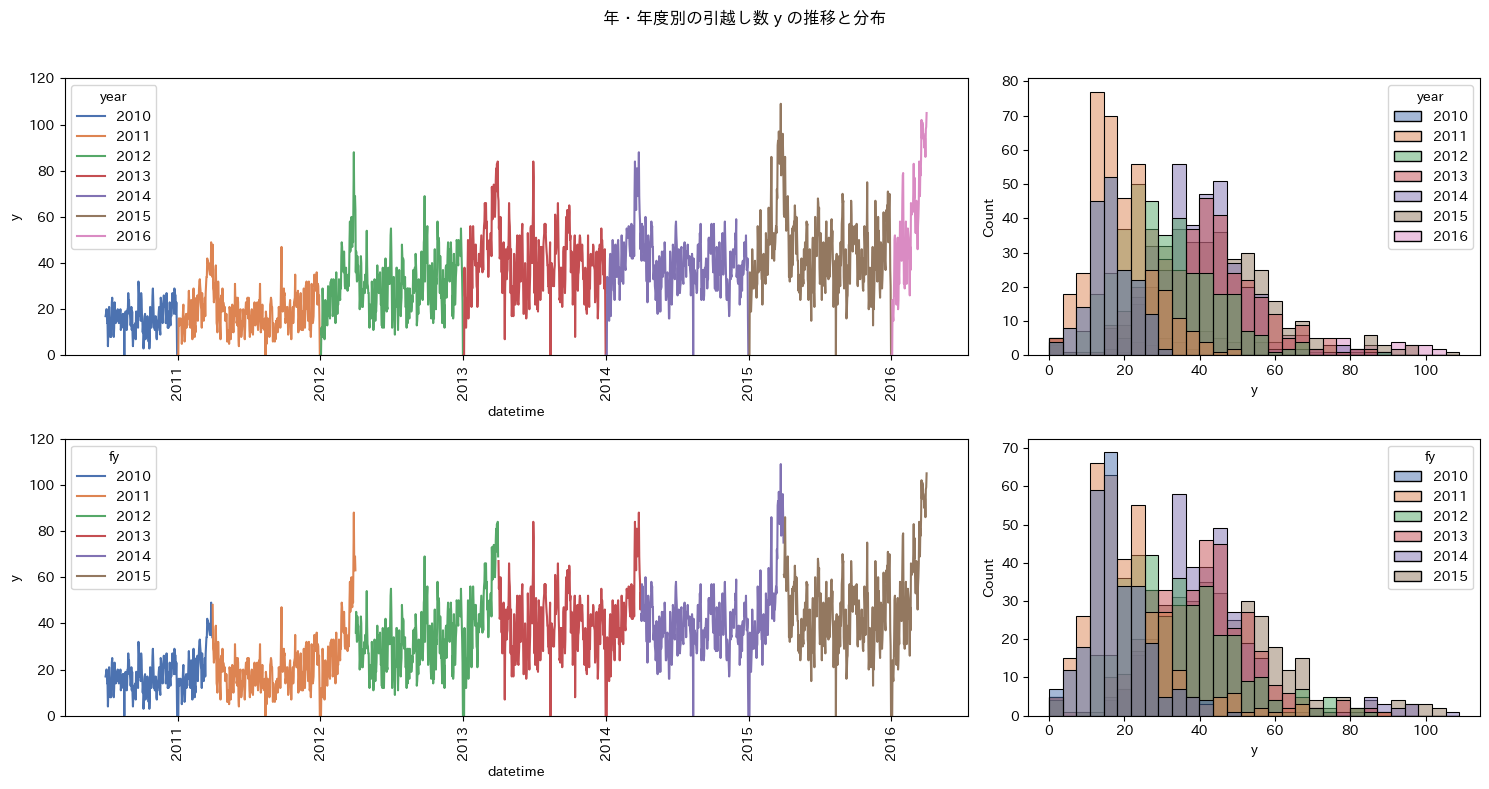

In [15]:
train = (
    train
    .with_columns([
        pl.col("datetime").dt.year().alias("year"),
        pl.when(pl.col("datetime").dt.month() <= 3).then(pl.col("datetime").dt.year() - 1)
        .otherwise(pl.col("datetime").dt.year())
        .alias("fy")
    ])
)

fig, axes = plt.subplots(
    nrows = 2, ncols = 2, # axの縦・横の数
    height_ratios = [1, 1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 8)
)

# 描画
g_time_year = sns.lineplot(data = train, x = "datetime", y = "y", hue = "year", palette = "deep", ax = axes[0, 0])
g_hist_year = sns.histplot(data = train, x = "y", hue = "year", palette = "deep", ax = axes[0, 1])

g_time_fy = sns.lineplot(data = train, x = "datetime", y = "y", hue = "fy", palette = "deep", ax = axes[1, 0])
g_hist_fy = sns.histplot(data = train, x = "y", hue = "fy", palette = "deep", ax = axes[1, 1])


# 調整
plt.setp(g_time_year.get_xticklabels(), rotation = 90)
plt.setp(g_time_year, ylim = (0, 120))
plt.setp(g_time_fy.get_xticklabels(), rotation = 90)
plt.setp(g_time_fy, ylim = (0, 120))

plt.suptitle("年・年度別の引越し数 y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

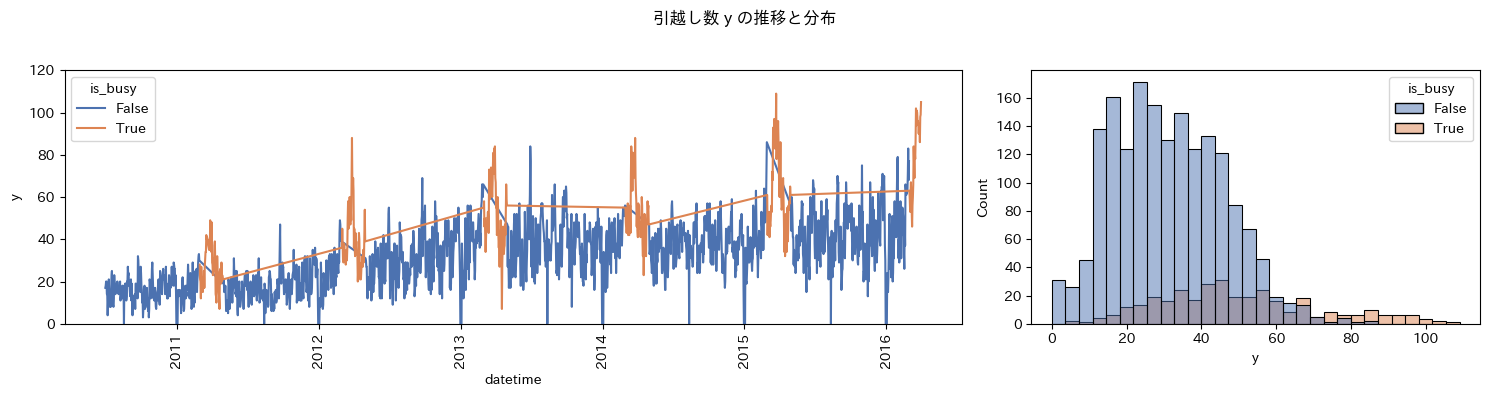

In [16]:
train = train.with_columns(
    (
        (pl.col("datetime").dt.month() == 3)
        | (pl.col("datetime").dt.month() == 4)
    ).alias("is_busy")
)

fig, axes = plt.subplots(
    nrows = 1, ncols = 2, # axの縦・横の数
    height_ratios = [1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 4)
)

# 描画
g_time = sns.lineplot(data = train, x = "datetime", y = "y", hue = "is_busy", palette = "deep", ax = axes[0])
g_hist = sns.histplot(data = train, x = "y", hue = "is_busy", palette = "deep", ax = axes[1])

# 調整
plt.setp(g_time.get_xticklabels(), rotation = 90)
plt.setp(g_time, ylim = (0, 120))

plt.suptitle("引越し数 y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

In [17]:
with pl.Config(tbl_rows = -1):
    print(train.filter(pl.col("y") == 0))

shape: (29, 10)
┌────────────┬────────────┬─────┬────────┬───┬──────────┬──────┬──────┬─────────┐
│ id         ┆ datetime   ┆ y   ┆ client ┆ … ┆ price_pm ┆ year ┆ fy   ┆ is_busy │
│ ---        ┆ ---        ┆ --- ┆ ---    ┆   ┆ ---      ┆ ---  ┆ ---  ┆ ---     │
│ str        ┆ date       ┆ i64 ┆ i64    ┆   ┆ i64      ┆ i32  ┆ i32  ┆ bool    │
╞════════════╪════════════╪═════╪════════╪═══╪══════════╪══════╪══════╪═════════╡
│ 2010-08-18 ┆ 2010-08-18 ┆ 0   ┆ 0      ┆ … ┆ -1       ┆ 2010 ┆ 2010 ┆ false   │
│ 2010-12-31 ┆ 2010-12-31 ┆ 0   ┆ 0      ┆ … ┆ -1       ┆ 2010 ┆ 2010 ┆ false   │
│ 2011-01-01 ┆ 2011-01-01 ┆ 0   ┆ 0      ┆ … ┆ -1       ┆ 2011 ┆ 2010 ┆ false   │
│ 2011-01-02 ┆ 2011-01-02 ┆ 0   ┆ 0      ┆ … ┆ -1       ┆ 2011 ┆ 2010 ┆ false   │
│ 2011-01-03 ┆ 2011-01-03 ┆ 0   ┆ 0      ┆ … ┆ -1       ┆ 2011 ┆ 2010 ┆ false   │
│ 2011-08-14 ┆ 2011-08-14 ┆ 0   ┆ 0      ┆ … ┆ 0        ┆ 2011 ┆ 2011 ┆ false   │
│ 2011-12-31 ┆ 2011-12-31 ┆ 0   ┆ 0      ┆ … ┆ -1       ┆ 2011 ┆ 2011 ┆ false   │


In [18]:
train = train.filter( pl.col("y") != 0 )
test_close = test.filter(pl.col("close") == 1)[["id"]]
test_close = test_close.with_columns(pl.Series("y", [0.0] * len(test_close)))
test = test.filter(pl.col("close") != 1)

print(test_close)

shape: (5, 2)
┌────────────┬─────┐
│ id         ┆ y   │
│ ---        ┆ --- │
│ str        ┆ f64 │
╞════════════╪═════╡
│ 2016-08-16 ┆ 0.0 │
│ 2016-12-31 ┆ 0.0 │
│ 2017-01-01 ┆ 0.0 │
│ 2017-01-02 ┆ 0.0 │
│ 2017-01-03 ┆ 0.0 │
└────────────┴─────┘


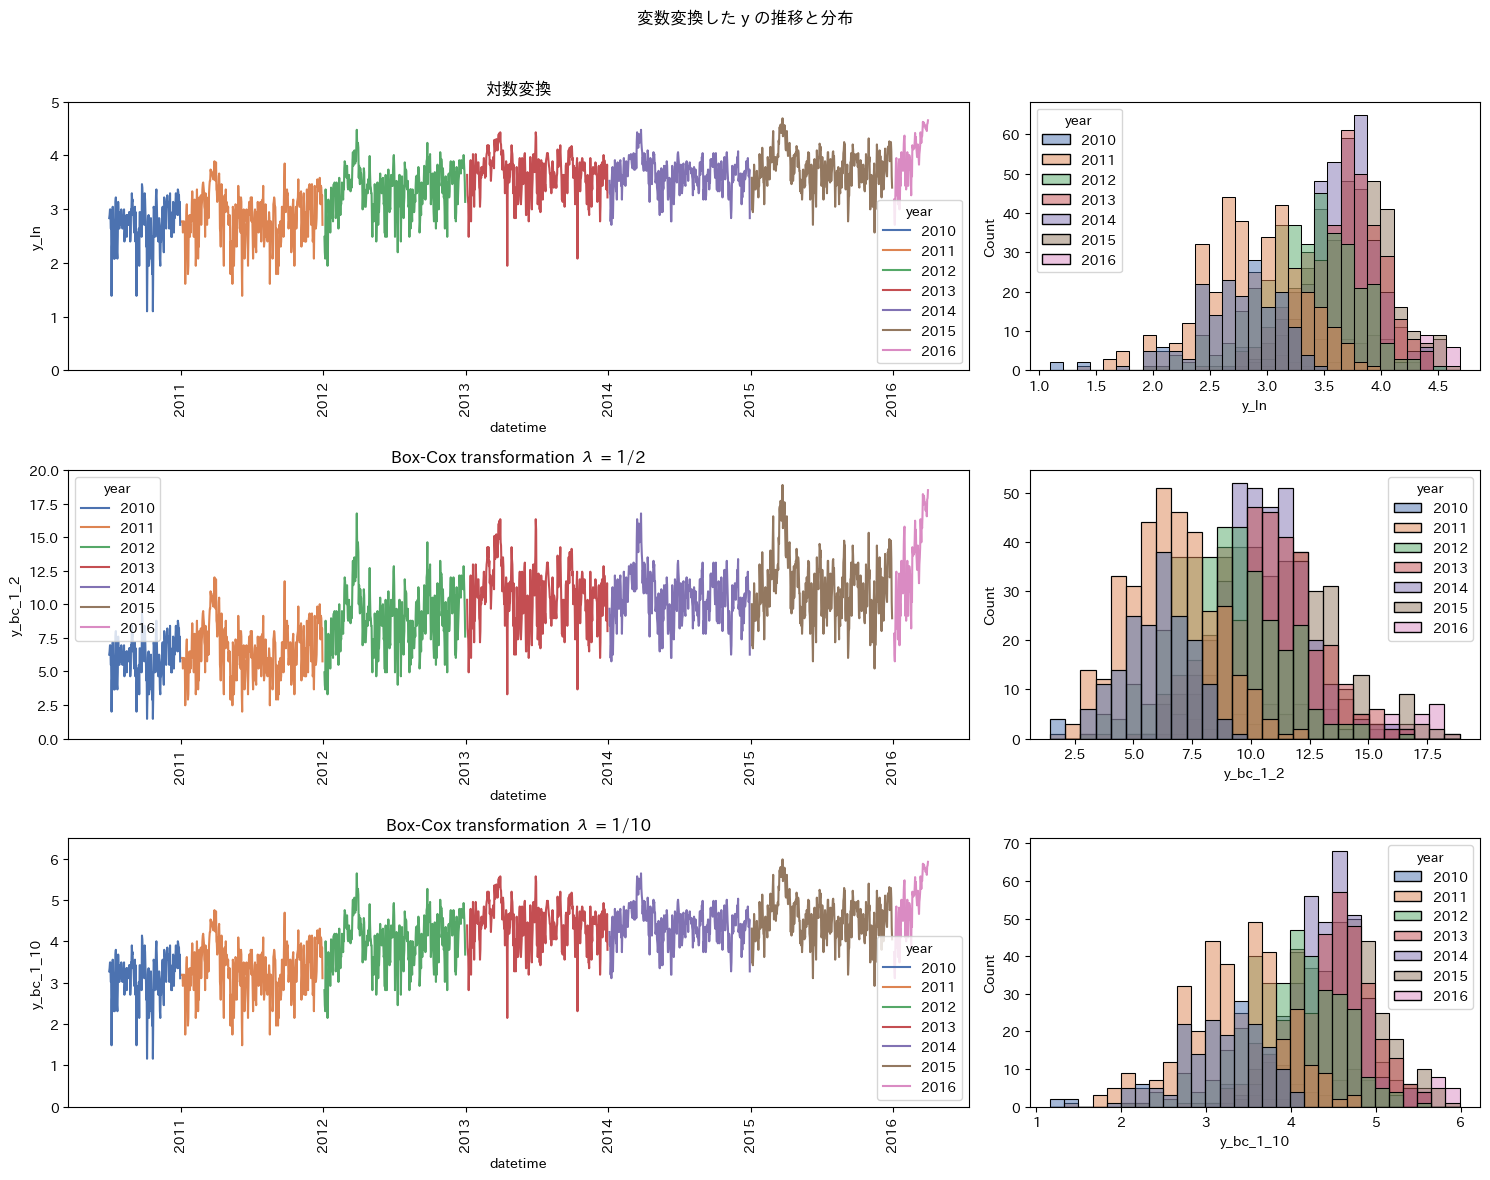

In [19]:
train = (
    train
    .with_columns([
        pl.col("y").log().alias("y_ln"),
        ((pl.col("y").pow(1 / 2) - 1) / (1/2)).alias("y_bc_1_2"),
        ((pl.col("y").pow(1 / 10) - 1) / (1/10)).alias("y_bc_1_10"),
    ])
)

fig, axes = plt.subplots(
    nrows = 3, ncols = 2, # axの縦・横の数
    height_ratios = [1, 1, 1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 12)
)

# 描画
g_time_ln = sns.lineplot(data = train, x = "datetime", y = "y_ln", hue = "year", palette = "deep", ax = axes[0, 0])
g_hist_ln = sns.histplot(data = train, x = "y_ln", hue = "year", palette = "deep", ax = axes[0, 1])

g_time_bc_1_2 = sns.lineplot(data = train, x = "datetime", y = "y_bc_1_2", hue = "year", palette = "deep", ax = axes[1, 0])
g_hist_bc_1_2 = sns.histplot(data = train, x = "y_bc_1_2", hue = "year", palette = "deep", ax = axes[1, 1])

g_time_bc_1_10 = sns.lineplot(data = train, x = "datetime", y = "y_bc_1_10", hue = "year", palette = "deep", ax = axes[2, 0])
g_hist_bc_1_10 = sns.histplot(data = train, x = "y_bc_1_10", hue = "year", palette = "deep", ax = axes[2, 1])


# 調整
plt.setp(g_time_ln.get_xticklabels(), rotation = 90)
plt.setp(g_time_ln, ylim = (0, 5), title = "対数変換")
plt.setp(g_time_bc_1_2.get_xticklabels(), rotation = 90)
plt.setp(g_time_bc_1_2, ylim = (0, 20), title = "Box-Cox transformation λ = 1/2")
plt.setp(g_time_bc_1_10.get_xticklabels(), rotation = 90)
plt.setp(g_time_bc_1_10, ylim = (0, 6.5), title = "Box-Cox transformation λ = 1/10")

plt.suptitle("変数変換した y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

In [20]:
print("訓練データの休業日の数", len(train.filter(pl.col("close") == 1)), "\nテストデータの休業日の数", len(test.filter(pl.col("close") == 1)))

訓練データの休業日の数 0 
テストデータの休業日の数 0


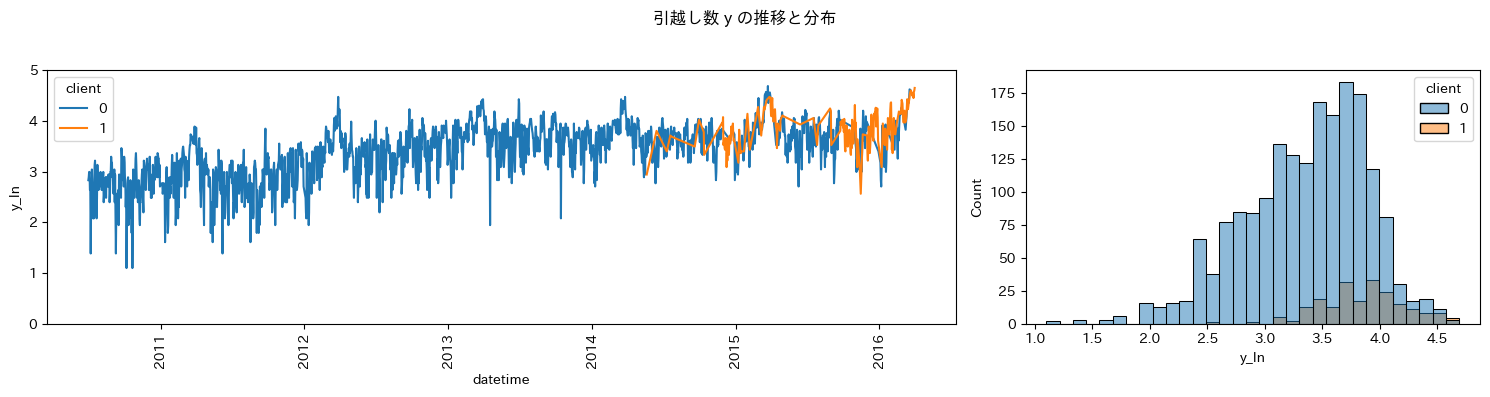

In [21]:
fig, axes = plt.subplots(
    nrows = 1, ncols = 2, # axの縦・横の数
    height_ratios = [1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 4)
)

# 描画
g_time = sns.lineplot(data = train, x = "datetime", y = "y_ln", hue = "client", ax = axes[0])
g_hist = sns.histplot(data = train, x = "y_ln", hue = "client", ax = axes[1])

# 調整
plt.setp(g_time.get_xticklabels(), rotation = 90)
plt.setp(g_time, ylim = (0, 5))

plt.suptitle("引越し数 y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

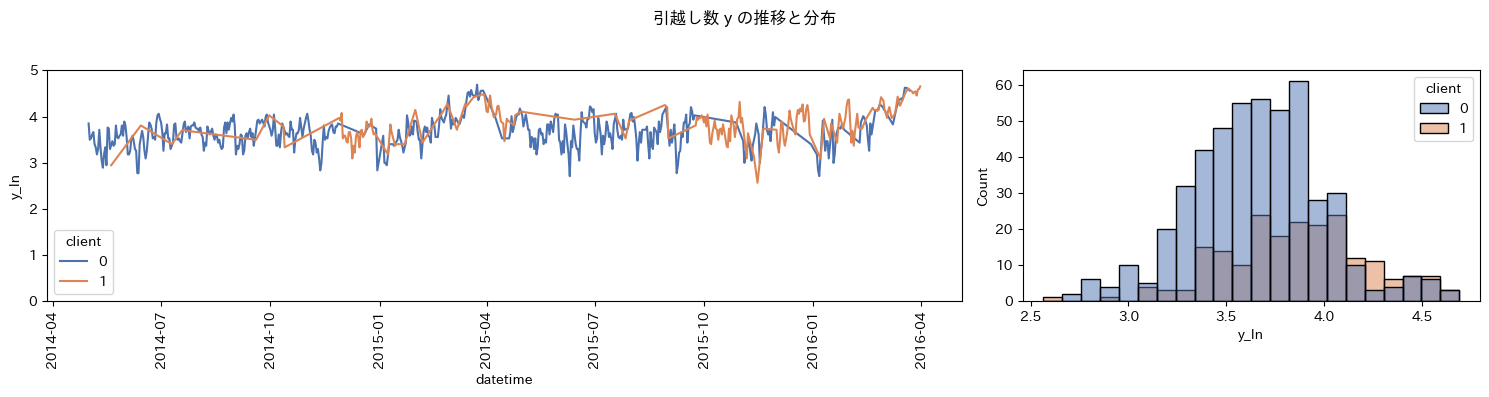

In [22]:
fig, axes = plt.subplots(
    nrows = 1, ncols = 2, # axの縦・横の数
    height_ratios = [1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 4)
)

# 描画
g_time = sns.lineplot(data = train.filter(pl.col("datetime") >= date(2014, 5, 1)), x = "datetime", y = "y_ln", hue = "client", palette = "deep", ax = axes[0])
g_hist = sns.histplot(data = train.filter(pl.col("datetime") >= date(2014, 5, 1)), x = "y_ln", hue = "client", palette = "deep", ax = axes[1])

# 調整
plt.setp(g_time.get_xticklabels(), rotation = 90)
plt.setp(g_time, ylim = (0, 5))

plt.suptitle("引越し数 y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

In [23]:
print("法人が絡む特殊な引越しを扱う日の引越し数平均", np.round(train.filter(pl.col("datetime") >= date(2014, 5, 1)).filter(pl.col("client") == 1)["y"].mean(), decimals = 2))
print("それ以外の日の引越し数平均", np.round(train.filter(pl.col("datetime") >= date(2014, 5, 1)).filter(pl.col("client") == 0)["y"].mean(), decimals = 2))

法人が絡む特殊な引越しを扱う日の引越し数平均 50.58
それ以外の日の引越し数平均 41.26


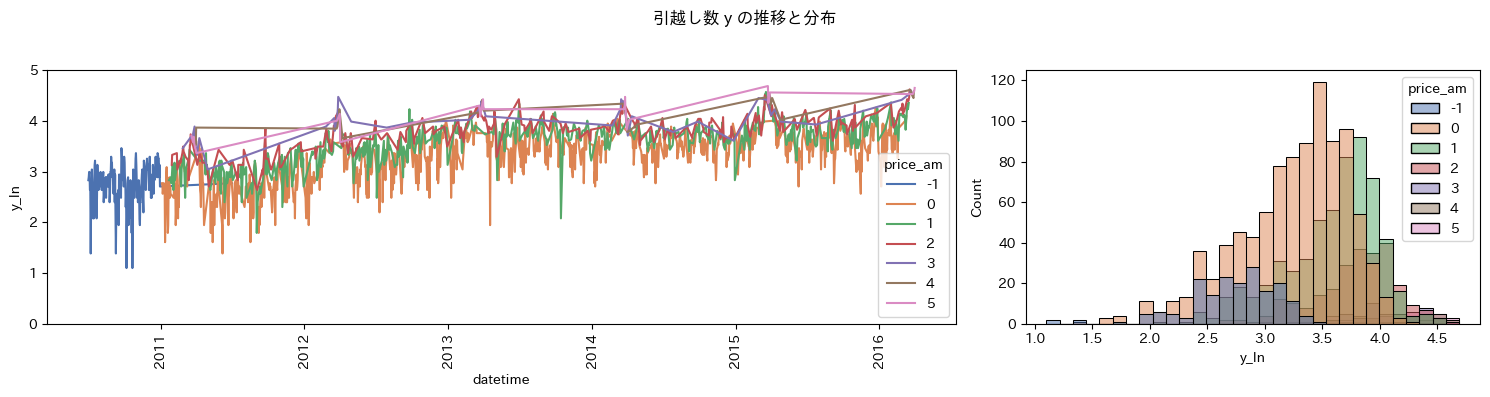

In [24]:
fig, axes = plt.subplots(
    nrows = 1, ncols = 2, # axの縦・横の数
    height_ratios = [1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 4)
)

# 描画
g_time = sns.lineplot(data = train, x = "datetime", y = "y_ln", hue = "price_am", palette = "deep", ax = axes[0])
g_hist = sns.histplot(data = train, x = "y_ln", hue = "price_am", palette = "deep", ax = axes[1])

# 調整
plt.setp(g_time.get_xticklabels(), rotation = 90)
plt.setp(g_time, ylim = (0, 5))

plt.suptitle("引越し数 y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

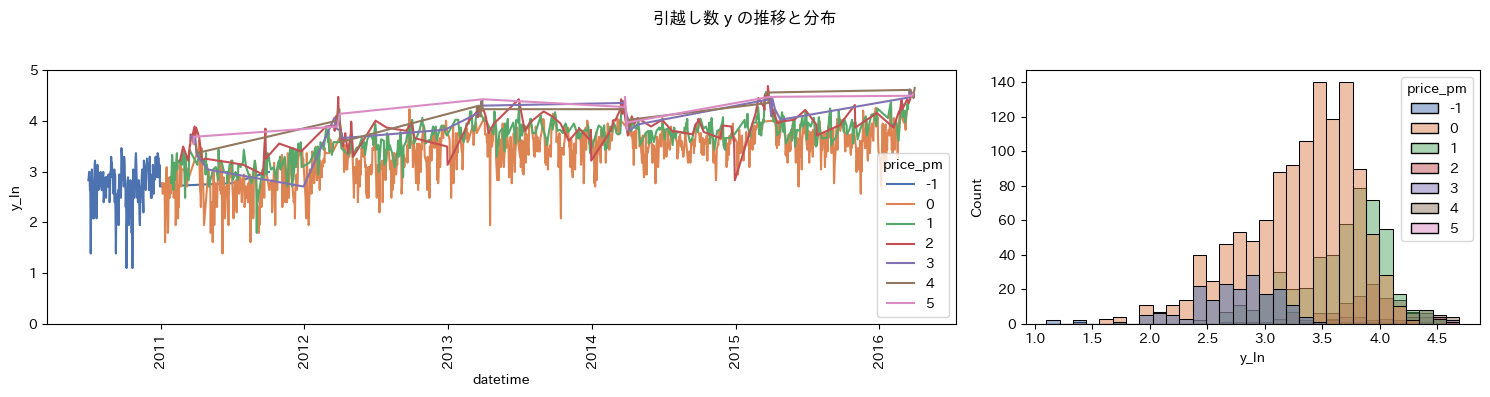

In [25]:
fig, axes = plt.subplots(
    nrows = 1, ncols = 2, # axの縦・横の数
    height_ratios = [1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 4)
)

# 描画
g_time = sns.lineplot(data = train, x = "datetime", y = "y_ln", hue = "price_pm", palette = "deep", ax = axes[0])
g_hist = sns.histplot(data = train, x = "y_ln", hue = "price_pm", palette = "deep", ax = axes[1])

# 調整
plt.setp(g_time.get_xticklabels(), rotation = 90)
plt.setp(g_time, ylim = (0, 5))

plt.suptitle("引越し数 y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

In [26]:
print("2010年のデータ数", len(train.filter(pl.col("datetime") <= date(2010, 12, 31))))
print("2010年の午前の料金区分が欠測しているデータ数", len(train.filter((pl.col("datetime") <= date(2010, 12, 31)) & (pl.col("price_am") == -1))))
print("2010年の午後の料金区分が欠測しているデータ数", len(train.filter((pl.col("datetime") <= date(2010, 12, 31)) & (pl.col("price_pm") == -1))))

2010年のデータ数 182
2010年の午前の料金区分が欠測しているデータ数 182
2010年の午後の料金区分が欠測しているデータ数 182


In [27]:
train = pl.read_csv(f"{path}train.csv")
test = pl.read_csv(f"{path}test.csv")
sample_submit = pl.read_csv(f"{path}sample_submit.csv", has_header = False)
# IDと日時を分散する
train = train.insert_column(0, train["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))
test = test.insert_column(0, test["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))

# 休業日(close = 1)を分離する
train = train.filter( pl.col("y") != 0 )
test_close = test.filter(pl.col("close") == 1)[["id"]]
test_close = test_close.with_columns(pl.Series("y", [0.0] * len(test_close)))
test = test.filter(pl.col("close") != 1)

# 目的変数を対数変換する
train = train.insert_column(3, train["y"].log().alias("y_ln"))

# ユニーク値が1種類のカラムを削除する
train = train.drop("close")
test = test.drop("close")

# 2010年の全ての行において料金区分が欠測値のため削除する
train = train.filter(pl.col("datetime") >= date(2011, 1, 1))

print(train.head())

shape: (5, 7)
┌────────────┬────────────┬─────┬──────────┬────────┬──────────┬──────────┐
│ id         ┆ datetime   ┆ y   ┆ y_ln     ┆ client ┆ price_am ┆ price_pm │
│ ---        ┆ ---        ┆ --- ┆ ---      ┆ ---    ┆ ---      ┆ ---      │
│ str        ┆ date       ┆ i64 ┆ f64      ┆ i64    ┆ i64      ┆ i64      │
╞════════════╪════════════╪═════╪══════════╪════════╪══════════╪══════════╡
│ 2011-01-04 ┆ 2011-01-04 ┆ 16  ┆ 2.772589 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-05 ┆ 2011-01-05 ┆ 16  ┆ 2.772589 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-06 ┆ 2011-01-06 ┆ 13  ┆ 2.564949 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-07 ┆ 2011-01-07 ┆ 14  ┆ 2.639057 ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-08 ┆ 2011-01-08 ┆ 16  ┆ 2.772589 ┆ 0      ┆ 0        ┆ 0        │
└────────────┴────────────┴─────┴──────────┴────────┴──────────┴──────────┘


In [28]:
# 訓練データ
train_pandas = (
    train
    .select([
        "datetime",# 日時
        "y_ln"# 目的変数
    ])
    .rename({
        "datetime": "ds",# 日時のカラム名を ds にする必要がある。
        "y_ln": "y"# 目的変数のカラム名を y にする必要がある。
        })
    .to_pandas()# 機械学習ライブラリとの親和性の高いPnadasに変換する
)
# テストデータ
test_pandas = (
    test
    .select([
        "datetime",# 日時
    ])
    .rename({"datetime": "ds"})# 日時を ds にする必要がある。
    .to_pandas()# 機械学習ライブラリとの親和性の高いPnadasに変換する
)

# モデルの学習
model = Prophet()
model.fit(train_pandas)

# 推定値の算出
forecast_train = pl.Series("y_prophet", model.predict(train_pandas)["yhat"].values)
forecast_test = pl.Series("y_prophet", model.predict(test_pandas)["yhat"].values)

# 推定値をDataFrameに追加する
train = train.insert_column(4, forecast_train)
test = test.insert_column(2, forecast_test)

# 対数変換した目的変数とProphetの予測値の差分を計算する
train = train.insert_column(5, (train["y_ln"] - train["y_prophet"]).alias("y_difference"))

# 確認
print(train.head())
print(test.head())

# 不要なDataFrameを削除する
del train_pandas, test_pandas

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgk2_c5u/03fhpy8i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvgk2_c5u/8as53cl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95840', 'data', 'file=/tmp/tmpvgk2_c5u/03fhpy8i.json', 'init=/tmp/tmpvgk2_c5u/8as53cl1.json', 'output', 'file=/tmp/tmpvgk2_c5u/prophet_modelrrn1tyd0/prophet_model-20250515034610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:46:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


shape: (5, 9)
┌────────────┬────────────┬─────┬──────────┬───┬──────────────┬────────┬──────────┬──────────┐
│ id         ┆ datetime   ┆ y   ┆ y_ln     ┆ … ┆ y_difference ┆ client ┆ price_am ┆ price_pm │
│ ---        ┆ ---        ┆ --- ┆ ---      ┆   ┆ ---          ┆ ---    ┆ ---      ┆ ---      │
│ str        ┆ date       ┆ i64 ┆ f64      ┆   ┆ f64          ┆ i64    ┆ i64      ┆ i64      │
╞════════════╪════════════╪═════╪══════════╪═══╪══════════════╪════════╪══════════╪══════════╡
│ 2011-01-04 ┆ 2011-01-04 ┆ 16  ┆ 2.772589 ┆ … ┆ -0.015634    ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-05 ┆ 2011-01-05 ┆ 16  ┆ 2.772589 ┆ … ┆ -0.016155    ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-06 ┆ 2011-01-06 ┆ 13  ┆ 2.564949 ┆ … ┆ -0.224315    ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-07 ┆ 2011-01-07 ┆ 14  ┆ 2.639057 ┆ … ┆ -0.150727    ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-08 ┆ 2011-01-08 ┆ 16  ┆ 2.772589 ┆ … ┆ -0.017716    ┆ 0      ┆ 0        ┆ 0        │
└────────────┴────────────┴─────┴───

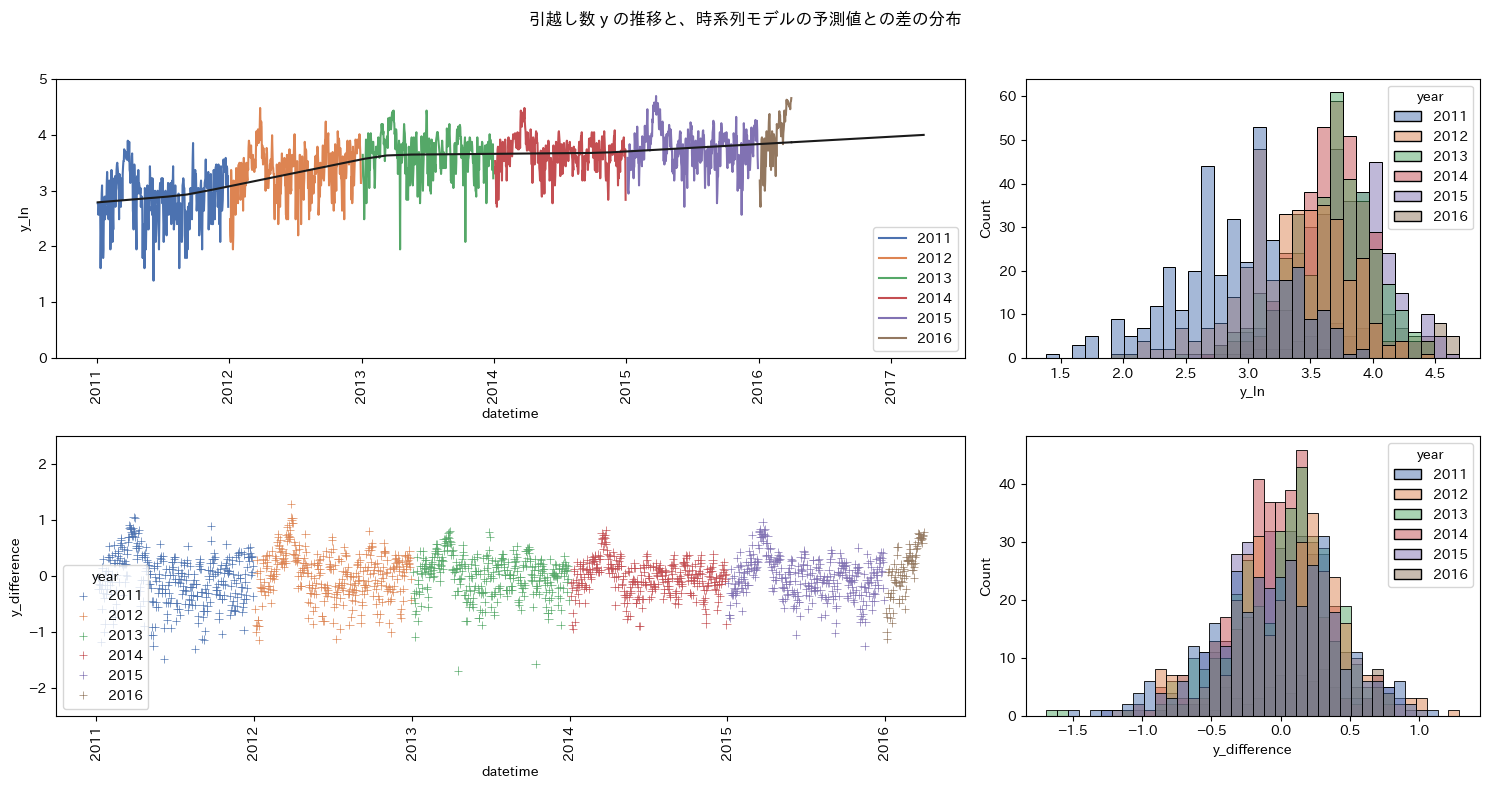

In [29]:
train = train.with_columns(pl.col("datetime").dt.year().alias("year"))
test = test.with_columns(pl.col("datetime").dt.year().alias("year"))

fig, axes = plt.subplots(
    nrows = 2, ncols = 2, # axの縦・横の数
    height_ratios = [1, 1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 8)
)

# 描画
g_time_train = sns.lineplot(data = train, x = "datetime", y = "y_ln", hue = "year", palette = "deep", ax = axes[0, 0])
g_time_prophet_train = sns.lineplot(data = train, x = "datetime", y = "y_prophet", ax = axes[0, 0], color = ".1")
g_time_prophet_test = sns.lineplot(data = test, x = "datetime", y = "y_prophet", ax = axes[0, 0], color = ".1")
g_hist_train = sns.histplot(data = train, x = "y_ln", hue = "year", palette = "deep", ax = axes[0, 1])
# 差分
g_residual_train = sns.scatterplot(data = train, x = "datetime", y = "y_difference", hue = "year", palette = "deep", marker = "+", ax = axes[1, 0])
g_residual_hist_train = sns.histplot(data = train, x = "y_difference", hue = "year", palette = "deep", ax = axes[1, 1])

# 調整
plt.setp(g_time_train.get_xticklabels(), rotation = 90)
plt.setp(g_time_train, ylim = (0, 5))
plt.setp(g_residual_train.get_xticklabels(), rotation = 90)
plt.setp(g_residual_train, ylim = (-2.5, 2.5))

plt.suptitle("引越し数 y の推移と、時系列モデルの予測値との差の分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

# 不要なカラムの削除
train = train.drop("year")
test = test.drop("year")

In [30]:
# 機械学習ライブラリと親和性の高いPandasに変換する
train_pandas = train.to_pandas().set_index("id")

# 目的変数と特徴量
target_column = "y_difference"
feature_columns = ["client", "price_am", "price_pm"]

# 訓練データと評価データに分割するマスク
np.random.seed(1192)
train_mask_1 = np.random.choice([True, False], size = len(train_pandas), p = [0.75, 0.25])

# 説明変数、目的変数の分割
train_temp, valid_temp = train_pandas[train_mask_1], train_pandas[~train_mask_1]
X_train, y_train = train_temp[feature_columns], train_temp[target_column]
X_valid, y_valid = valid_temp[feature_columns], valid_temp[target_column]

訓練データの評価関数: 7.0550623
評価データの評価関数: 7.1672201


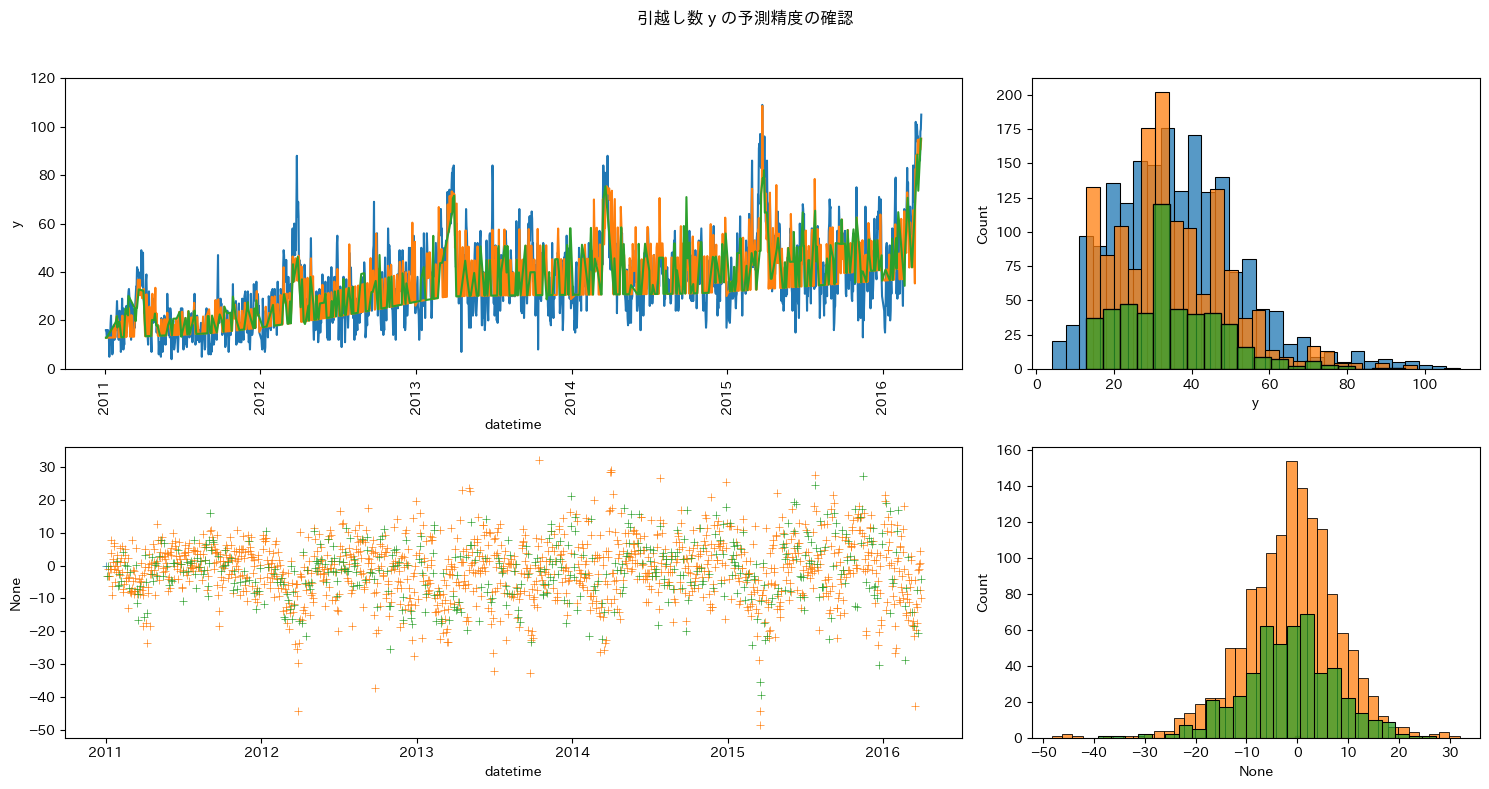

[Text(0.5, 1.0, '特徴量の重要度')]

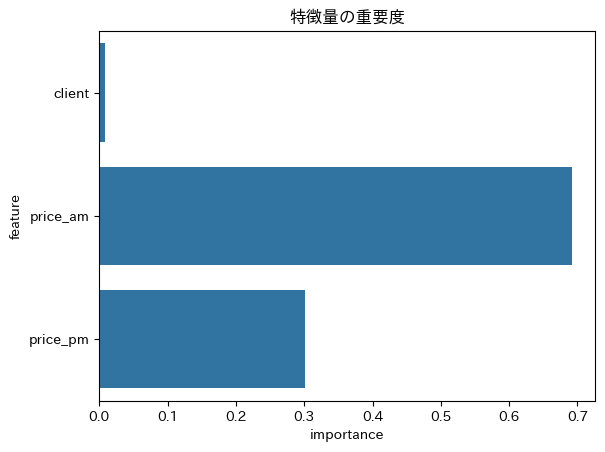

In [31]:
# 学習
est = GradientBoostingRegressor().fit(X_train, y_train)

# 予測(対数変換を逆変換する)
y_pred_train = np.exp(est.predict(X_train) + train_temp["y_prophet"])
y_pred_valid = np.exp(est.predict(X_valid) + valid_temp["y_prophet"])


# 予測精度の確認
print("訓練データの評価関数:", np.round(mean_absolute_error(train_temp["y"], y_pred_train), decimals = 7))# 小数第7位はコンペスコアの有効数字
print("評価データの評価関数:", np.round(mean_absolute_error(valid_temp["y"], y_pred_valid), decimals = 7))

# 予測結果の確認
fig, axes = plt.subplots(
    nrows = 2, ncols = 2, # axの縦・横の数
    height_ratios = [1, 1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 8)
)

# 描画
g_time_train = sns.lineplot(data = train, x = "datetime", y = "y", ax = axes[0, 0])
g_predict_train = sns.lineplot(x = train_temp["datetime"], y = y_pred_train, ax = axes[0, 0])
g_predict_valid = sns.lineplot(x = valid_temp["datetime"], y = y_pred_valid, ax = axes[0, 0])

g_hist_train = sns.histplot(data = train, x = "y", ax = axes[0, 1])
g_predict_hist_train = sns.histplot(x = y_pred_train, ax = axes[0, 1])
g_predict_hist_valid = sns.histplot(x = y_pred_valid, ax = axes[0, 1])

# 残差
g_residual_dummy = sns.scatterplot(x = [date(2011, 1, 1)], y = 0, marker = "+", ax = axes[1, 0])
g_residual_train = sns.scatterplot(x = train_temp["datetime"], y = y_pred_train - train_temp["y"], marker = "+", ax = axes[1, 0])
g_residual_valid = sns.scatterplot(x = valid_temp["datetime"], y = y_pred_valid - valid_temp["y"], marker = "+", ax = axes[1, 0])

g_residual_hist_dummy = sns.histplot(x = [0], ax = axes[1, 1])
g_residual_hist_train = sns.histplot(x = y_pred_train - train_temp["y"], ax = axes[1, 1])
g_residual_hist_valid = sns.histplot(x = y_pred_valid - valid_temp["y"], ax = axes[1, 1])


# 調整
plt.setp(g_time_train.get_xticklabels(), rotation = 90)
plt.setp(g_time_train, ylim = (0, 120))

plt.suptitle("引越し数 y の予測精度の確認")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

# 特徴量の重要度
df_feature_importance = pl.DataFrame({
    "feature": est.feature_names_in_,
    "importance": est.feature_importances_
})
g_importance = sns.barplot(data = df_feature_importance, x = "importance", y = "feature")
plt.setp(g_importance, title = "特徴量の重要度")

In [32]:
# Pandasに変換
train_busy_pandas = train.filter( (pl.col("datetime").dt.month() == 3) | (pl.col("datetime").dt.month() == 4) ).to_pandas().set_index("id")
train_other_pandas = train.filter( ~((pl.col("datetime").dt.month() == 3) | (pl.col("datetime").dt.month() == 4)) ).to_pandas().set_index("id")

# 目的変数と特徴量
target_column = "y_difference"
feature_columns = ["client", "price_am", "price_pm"]

# 訓練データと評価データに分割するマスク
np.random.seed(1192)
train_mask_busy_1 = np.random.choice([True, False], size = len(train_busy_pandas), p = [0.75, 0.25])
train_mask_other_1 = np.random.choice([True, False], size = len(train_other_pandas), p = [0.75, 0.25])


# 説明変数、目的変数の分割
train_busy_temp, valid_busy_temp = train_busy_pandas[train_mask_busy_1], train_busy_pandas[~train_mask_busy_1]
X_train_busy, y_train_busy = train_busy_temp[feature_columns], train_busy_temp[target_column]
X_valid_busy, y_valid_busy = valid_busy_temp[feature_columns], valid_busy_temp[target_column]

train_other_temp, valid_other_temp = train_other_pandas[train_mask_other_1], train_other_pandas[~train_mask_other_1]
X_train_other, y_train_other = train_other_temp[feature_columns], train_other_temp[target_column]
X_valid_other, y_valid_other = valid_other_temp[feature_columns], valid_other_temp[target_column]

繁忙期の訓練データの評価関数: 9.5789716
繁忙期の評価データの評価関数: 10.0807853
その他の時期の訓練データの評価関数: 6.6297095
その他の時期の評価データの評価関数: 6.2125759


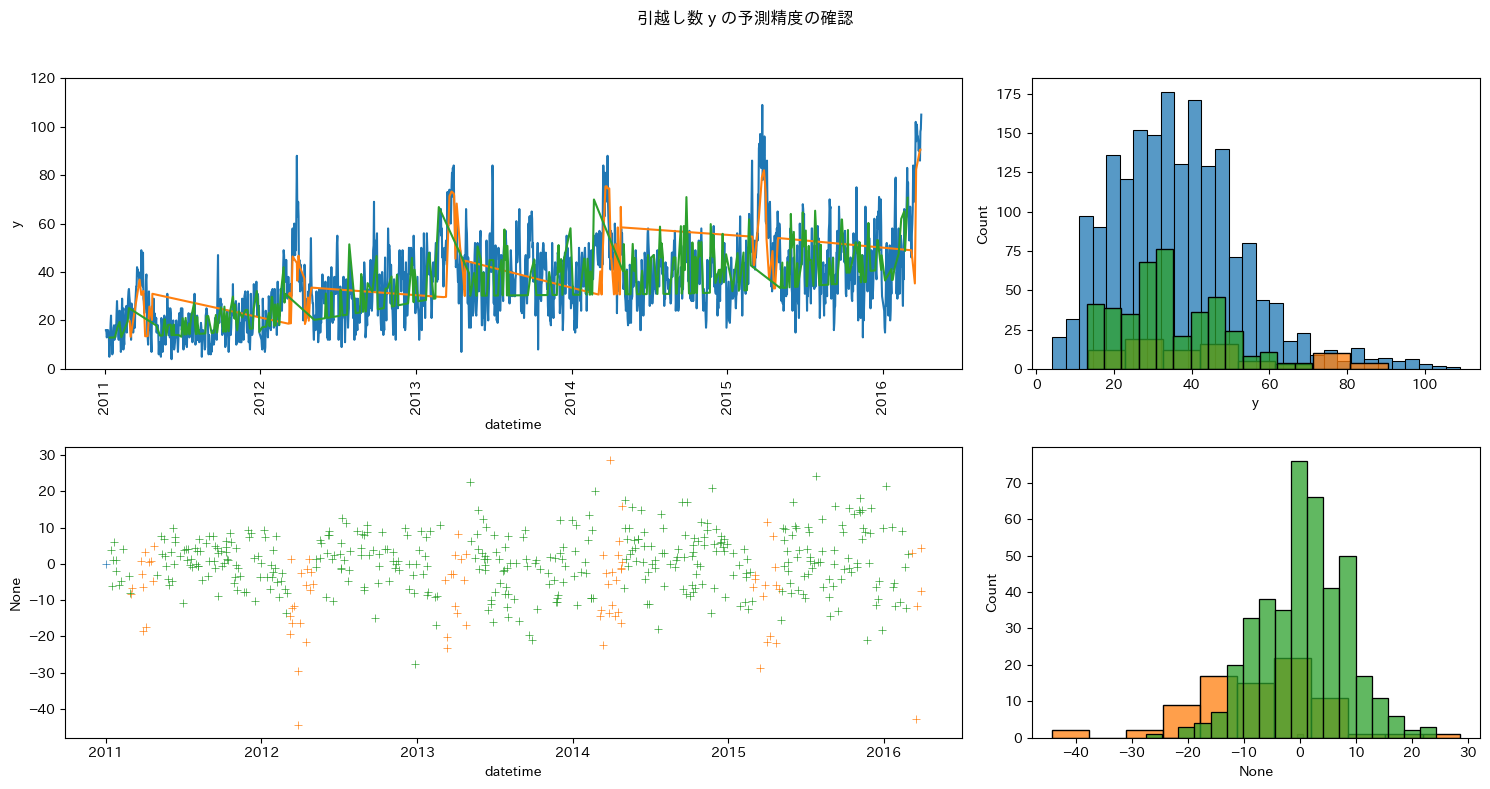

[Text(0.5, 1.0, '特徴量の重要度')]

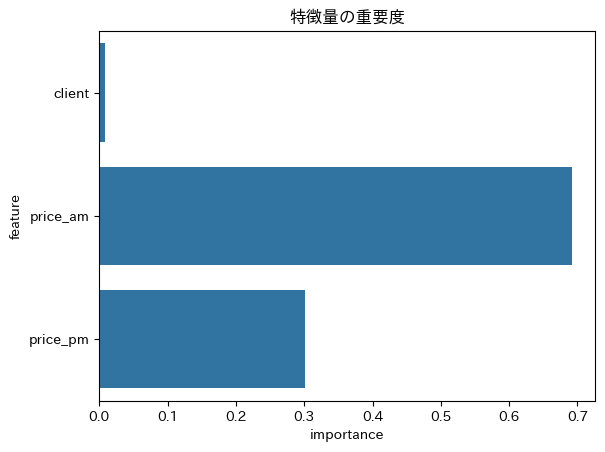

In [33]:
# 学習
est_busy = GradientBoostingRegressor(random_state = 1192).fit(X_train_busy, y_train_busy)
est_other = GradientBoostingRegressor(random_state = 1192).fit(X_train_other, y_train_other)


# 予測(対数変換を逆変換する)
y_pred_train_busy = np.exp(est.predict(X_train_busy) + train_busy_temp["y_prophet"])
y_pred_valid_busy = np.exp(est.predict(X_valid_busy) + valid_busy_temp["y_prophet"])

y_pred_train_other = np.exp(est.predict(X_train_other) + train_other_temp["y_prophet"])
y_pred_valid_other = np.exp(est.predict(X_valid_other) + valid_other_temp["y_prophet"])


# 予測精度の確認
# 小数第7位はコンペスコアの有効数字
print("繁忙期の訓練データの評価関数:", np.round(mean_absolute_error(train_busy_temp["y"], y_pred_train_busy), decimals = 7))
print("繁忙期の評価データの評価関数:", np.round(mean_absolute_error(valid_busy_temp["y"], y_pred_valid_busy), decimals = 7))
print("その他の時期の訓練データの評価関数:", np.round(mean_absolute_error(train_other_temp["y"], y_pred_train_other), decimals = 7))
print("その他の時期の評価データの評価関数:", np.round(mean_absolute_error(valid_other_temp["y"], y_pred_valid_other), decimals = 7))



# 予測結果の確認
fig, axes = plt.subplots(
    nrows = 2, ncols = 2, # axの縦・横の数
    height_ratios = [1, 1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 8)
)

# 描画
g_time_train = sns.lineplot(data = train, x = "datetime", y = "y", ax = axes[0, 0])
#g_predict_train_busy = sns.lineplot(x = train_busy_temp["datetime"], y = y_pred_train_busy, ax = axes[0, 0])
g_predict_valid_busy = sns.lineplot(x = valid_busy_temp["datetime"], y = y_pred_valid_busy, ax = axes[0, 0])

#g_predict_train_other = sns.lineplot(x = train_other_temp["datetime"], y = y_pred_train_other, ax = axes[0, 0])
g_predict_valid_other = sns.lineplot(x = valid_other_temp["datetime"], y = y_pred_valid_other, ax = axes[0, 0])


g_hist_train = sns.histplot(data = train, x = "y", ax = axes[0, 1])
#g_predict_hist_train_busy = sns.histplot(x = y_pred_train_busy, ax = axes[0, 1])
g_predict_hist_valid_busy = sns.histplot(x = y_pred_valid_busy, ax = axes[0, 1])
#g_predict_hist_train_other = sns.histplot(x = y_pred_train_other, ax = axes[0, 1])
g_predict_hist_valid_other = sns.histplot(x = y_pred_valid_other, ax = axes[0, 1])


# 残差
g_residual_dummy = sns.scatterplot(x = [date(2011, 1, 1)], y = 0, marker = "+", ax = axes[1, 0])
#g_residual_train_busy = sns.scatterplot(x = train_busy_temp["datetime"], y = y_pred_train_busy - train_busy_temp["y"], marker = "+", ax = axes[1, 0])
g_residual_valid_busy = sns.scatterplot(x = valid_busy_temp["datetime"], y = y_pred_valid_busy - valid_busy_temp["y"], marker = "+", ax = axes[1, 0])
#g_residual_train_other = sns.scatterplot(x = train_other_temp["datetime"], y = y_pred_train_other - train_other_temp["y"], marker = "+", ax = axes[1, 0])
g_residual_valid_other = sns.scatterplot(x = valid_other_temp["datetime"], y = y_pred_valid_other - valid_other_temp["y"], marker = "+", ax = axes[1, 0])

g_residual_hist_dummy = sns.histplot(x = [0], ax = axes[1, 1])
#g_residual_hist_train_busy = sns.histplot(x = y_pred_train_busy - train_busy_temp["y"], ax = axes[1, 1])
g_residual_hist_valid_busy = sns.histplot(x = y_pred_valid_busy - valid_busy_temp["y"], ax = axes[1, 1])
#g_residual_hist_train_other = sns.histplot(x = y_pred_train_other - train_other_temp["y"], ax = axes[1, 1])
g_residual_hist_valid_other = sns.histplot(x = y_pred_valid_other - valid_other_temp["y"], ax = axes[1, 1])

# 調整
plt.setp(g_time_train.get_xticklabels(), rotation = 90)
plt.setp(g_time_train, ylim = (0, 120))

plt.suptitle("引越し数 y の予測精度の確認")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

# 特徴量の重要度
df_feature_importance = pl.DataFrame({
    "feature": est.feature_names_in_,
    "importance": est.feature_importances_
})
g_importance = sns.barplot(data = df_feature_importance, x = "importance", y = "feature")
plt.setp(g_importance, title = "特徴量の重要度")

In [34]:
train = pl.read_csv(f"{path}train.csv")
test = pl.read_csv(f"{path}test.csv")
sample_submit = pl.read_csv(f"{path}sample_submit.csv", has_header = False)
# IDと日時を分散する
train = train.insert_column(0, train["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))
test = test.insert_column(0, test["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))

# 休業日(close = 1)を分離する
train = train.filter( pl.col("y") != 0 )
test_close = test.filter(pl.col("close") == 1)[["id"]]
test_close = test_close.with_columns(pl.Series("y", [0.0] * len(test_close)))
test = test.filter(pl.col("close") != 1)

# 目的変数を対数変換する
train = train.insert_column(3, train["y"].log().alias("y_ln"))

# ユニーク値が1種類のカラムを削除する
train = train.drop("close")
test = test.drop("close")

# 2010年の全ての行において料金区分が欠測値のため削除する
train = train.filter(pl.col("datetime") >= date(2011, 1, 1))

# Prophetの推定値と差分を追加する
train = train.insert_column(4, forecast_train)
test = test.insert_column(2, forecast_test)
train = train.insert_column(5, (train["y_ln"] - train["y_prophet"]).alias("y_difference"))

print(train.head())

shape: (5, 9)
┌────────────┬────────────┬─────┬──────────┬───┬──────────────┬────────┬──────────┬──────────┐
│ id         ┆ datetime   ┆ y   ┆ y_ln     ┆ … ┆ y_difference ┆ client ┆ price_am ┆ price_pm │
│ ---        ┆ ---        ┆ --- ┆ ---      ┆   ┆ ---          ┆ ---    ┆ ---      ┆ ---      │
│ str        ┆ date       ┆ i64 ┆ f64      ┆   ┆ f64          ┆ i64    ┆ i64      ┆ i64      │
╞════════════╪════════════╪═════╪══════════╪═══╪══════════════╪════════╪══════════╪══════════╡
│ 2011-01-04 ┆ 2011-01-04 ┆ 16  ┆ 2.772589 ┆ … ┆ -0.015634    ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-05 ┆ 2011-01-05 ┆ 16  ┆ 2.772589 ┆ … ┆ -0.016155    ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-06 ┆ 2011-01-06 ┆ 13  ┆ 2.564949 ┆ … ┆ -0.224315    ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-07 ┆ 2011-01-07 ┆ 14  ┆ 2.639057 ┆ … ┆ -0.150727    ┆ 0      ┆ 0        ┆ 0        │
│ 2011-01-08 ┆ 2011-01-08 ┆ 16  ┆ 2.772589 ┆ … ┆ -0.017716    ┆ 0      ┆ 0        ┆ 0        │
└────────────┴────────────┴─────┴───

In [35]:
train = (
    train
    # 日付の基本要素の追加
    .with_columns([
        # 年
        pl.col("datetime").dt.year().alias("year"),
        # 四半期・月・週・日(年の分割)
        pl.col("datetime").dt.quarter().alias("quarter"),
        pl.col("datetime").dt.month().alias("month"),
        pl.col("datetime").dt.week().alias("week"),
        pl.col("datetime").dt.ordinal_day().alias("ordinal_day"),
        # 週目・日・月末までの日数(月の分割)
        (pl.col("datetime").dt.day() // 7 + 1).alias("week_of_month"),
        pl.col("datetime").dt.day().alias("day"),
        # 曜日(週の分割)
        pl.col("datetime").dt.weekday().alias("day_of_week"),
    ])
    # 四半期はじめ, 月初めのフラグ
    .with_columns([
        pl.when((pl.col("month").is_in([1, 4, 7, 10])) & (pl.col("day") == 1)).then(1)
        .otherwise(0).alias("quarter_start"),
        pl.when((pl.col("month").is_in([3, 6, 9, 12])) & (pl.col("datetime") == pl.col("datetime").dt.month_end())).then(1)
        .otherwise(0).alias("quarter_end"),
        pl.when(pl.col("day") == 1).then(1)
        .otherwise(0).alias("month_start"),
        pl.when(pl.col("datetime") == pl.col("datetime").dt.month_end()).then(1)
        .otherwise(0).alias("month_end"),
    ])
    # 価格の和・差・積
    .with_columns([
        (pl.col("price_am") + pl.col("price_pm")).alias("price_sum"),
        (pl.col("price_am") - pl.col("price_pm")).alias("price_difference"),
        ((pl.col("price_am") + 1) * (pl.col("price_pm") + 1)).alias("price_product"),
    ])
)

In [36]:
test = (
    test
    # 日付の基本要素の追加
    .with_columns([
        # 年
        pl.col("datetime").dt.year().alias("year"),
        # 四半期・月・週・日(年の分割)
        pl.col("datetime").dt.quarter().alias("quarter"),
        pl.col("datetime").dt.month().alias("month"),
        pl.col("datetime").dt.week().alias("week"),
        pl.col("datetime").dt.ordinal_day().alias("ordinal_day"),
        # 週目・日・月末までの日数(月の分割)
        (pl.col("datetime").dt.day() // 7 + 1).alias("week_of_month"),
        pl.col("datetime").dt.day().alias("day"),
        # 曜日(週の分割)
        pl.col("datetime").dt.weekday().alias("day_of_week"),
    ])
    # 四半期はじめ, 月初めのフラグ
    .with_columns([
        pl.when((pl.col("month").is_in([1, 4, 7, 10])) & (pl.col("day") == 1)).then(1)
        .otherwise(0).alias("quarter_start"),
        pl.when((pl.col("month").is_in([3, 6, 9, 12])) & (pl.col("datetime") == pl.col("datetime").dt.month_end())).then(1)
        .otherwise(0).alias("quarter_end"),
        pl.when(pl.col("day") == 1).then(1)
        .otherwise(0).alias("month_start"),
        pl.when(pl.col("datetime") == pl.col("datetime").dt.month_end()).then(1)
        .otherwise(0).alias("month_end"),
    ])
    # 価格の和・差・積
    .with_columns([
        (pl.col("price_am") + pl.col("price_pm")).alias("price_sum"),
        (pl.col("price_am") - pl.col("price_pm")).alias("price_difference"),
        ((pl.col("price_am") + 1) * (pl.col("price_pm") + 1)).alias("price_product"),
    ])
)

In [37]:
# 祝日
holiday_list = []
for pair in jpholiday.between(date(2010, 1, 1), date(2017, 12, 31)):
    #print(pair[0], ":\t", pair[1])
    holiday_list.append(pair[0])


# GW
# https://9rando.info/j-holiday/gw/2011/
gw_list = [
    date(2011, 4, 29), date(2011, 4, 30), date(2011, 5, 1),
    date(2011, 5, 2),# 有給休暇の可能性
    date(2011, 5, 3), date(2011, 5, 4), date(2011, 5, 5),

    date(2012, 4, 28), date(2012, 4, 29), date(2012, 4, 30), date(2012, 5, 1),
    date(2012, 5, 2),# 有休
    date(2012, 5, 3), date(2012, 5, 4), date(2012, 5, 5), date(2012, 5, 5),

    date(2013, 4, 27), date(2013, 4, 28), date(2013, 4, 29),
    date(2013, 4, 30), date(2013, 5, 1), date(2013, 5, 2),# 有休
    date(2013, 5, 3), date(2013, 5, 4), date(2013, 5, 5), date(2013, 5, 5), date(2013, 5, 6),

    date(2014, 4, 29),
    date(2014, 4, 30), date(2014, 5, 1), date(2014, 5, 2),# 有休
    date(2014, 5, 3), date(2014, 5, 4), date(2014, 5, 5), date(2014, 5, 5), date(2014, 5, 6),

    date(2015, 4, 29),
    date(2015, 4, 30), date(2015, 5, 1),# 有休
    date(2015, 5, 2), date(2015, 5, 3), date(2015, 5, 4), date(2015, 5, 5), date(2015, 5, 5), date(2015, 5, 6),

    date(2016, 4, 29), date(2016, 4, 30), date(2016, 5, 1),
    date(2016, 5, 2),# 有休
    date(2016, 5, 3), date(2016, 5, 4), date(2016, 5, 5),

    date(2017, 4, 29), date(2017, 4, 30),
    date(2017, 5, 1), date(2017, 5, 2),# 有休
    date(2017, 5, 3), date(2017, 5, 4), date(2017, 5, 5), date(2017, 5, 6), date(2017, 5, 7),
]


# お盆
# https://9rando.info/j-holiday/obon/2011/
obon_list = [
    date(2011, 8, 13), date(2011, 8, 14), date(2011, 8, 15), date(2011, 8, 16),
    date(2012, 8, 13), date(2012, 8, 14), date(2012, 8, 15), date(2012, 8, 16),
    date(2013, 8, 13), date(2013, 8, 14), date(2013, 8, 15), date(2013, 8, 16),
    date(2014, 8, 13), date(2014, 8, 14), date(2014, 8, 15), date(2014, 8, 16),
    date(2015, 8, 13), date(2015, 8, 14), date(2015, 8, 15), date(2015, 8, 16),
    date(2016, 8, 13), date(2016, 8, 14), date(2016, 8, 15), date(2016, 8, 16),
    date(2017, 8, 13), date(2017, 8, 14), date(2017, 8, 15), date(2017, 8, 16),
]


# SW
# https://9rando.info/j-holiday/sw/2011/
sw_list = [
    date(2011, 9, 17), date(2011, 9, 18), date(2011, 9, 19),
    date(2011, 9, 20), date(2011, 9, 21), date(2011, 9, 22),# 有休
    date(2011, 9, 23), date(2011, 9, 24), date(2011, 9, 25),

    date(2012, 9, 15), date(2012, 9, 16), date(2012, 9, 17),
    date(2012, 9, 18), date(2012, 9, 19), date(2012, 9, 20), date(2012, 9, 21),# 有休
    date(2012, 9, 22), date(2012, 9, 23), date(2012, 9, 24),

    date(2013, 9, 14),date(2013, 9, 15), date(2013, 9, 16),
    date(2013, 9, 17), date(2013, 9, 18), date(2013, 9, 19), date(2013, 9, 20),# 有休
    date(2013, 9, 21),date(2013, 9, 22), date(2013, 9, 23),

    date(2014, 9, 13), date(2014, 9, 14),date(2014, 9, 15),
    date(2014, 9, 16), date(2014, 9, 17), date(2014, 9, 18), date(2014, 9, 19),# 有休
    date(2014, 9, 20), date(2014, 9, 21),date(2014, 9, 22),

    date(2015, 9, 19), date(2015, 9, 20), date(2015, 9, 21),
    date(2015, 9, 22), date(2015, 9, 23),

    date(2016, 9, 17), date(2016, 9, 18), date(2016, 9, 19),
    date(2016, 9, 20), date(2016, 9, 21),# 有休
    date(2016, 9, 22),

    date(2017, 9, 16), date(2017, 9, 17), date(2017, 9, 18),
    date(2017, 9, 19), date(2017, 9, 20), date(2017, 9, 21), date(2017, 9, 22),# 有休
    date(2017, 9, 23), date(2017, 9, 24),
]


# 休日フラグを追加する
train = train.with_columns([
    # 祝日
    pl.when(pl.col("datetime").is_in(holiday_list)).then(1)
    .otherwise(0).alias("holiday"),
    # GW
    pl.when(pl.col("datetime").is_in(gw_list)).then(1)
    .otherwise(0).alias("gw"),
    # 盆
    pl.when(pl.col("datetime").is_in(obon_list)).then(1)
    .otherwise(0).alias("obon"),
    # SW
    pl.when(pl.col("datetime").is_in(sw_list)).then(1)
    .otherwise(0).alias("sw"),
    # 土日
    pl.when( pl.col("day_of_week") >= 6 ).then(1)
    .otherwise(0).alias("sat_sun"),
])

test = test.with_columns([
    # 祝日
    pl.when(pl.col("datetime").is_in(holiday_list)).then(1)
    .otherwise(0).alias("holiday"),
    # GW
    pl.when(pl.col("datetime").is_in(gw_list)).then(1)
    .otherwise(0).alias("gw"),
    # 盆
    pl.when(pl.col("datetime").is_in(obon_list)).then(1)
    .otherwise(0).alias("obon"),
    # SW
    pl.when(pl.col("datetime").is_in(sw_list)).then(1)
    .otherwise(0).alias("sw"),
    # 土日
    pl.when( pl.col("day_of_week") >= 6 ).then(1)
    .otherwise(0).alias("sat_sun"),
])

# 不要なリストを削除する
del holiday_list, gw_list, obon_list, sw_list

In [38]:
# 機械学習ライブラリと親和性の高いPandasに変換する
train_pandas = train.to_pandas().set_index("id")

# 目的変数と特徴量
target_column = "y_difference"
feature_columns = ['client', 'price_am', 'price_pm',
                    'year', 'quarter', 'month', 'week', 'ordinal_day', 'week_of_month', 'day', 'day_of_week',
                    'quarter_start', 'quarter_end', 'month_start', 'month_end',
                    'price_sum', 'price_difference', 'price_product',
                    'holiday', 'gw', 'obon', 'sw', 'sat_sun'
 ]

# 訓練データと評価データに分割するマスク
np.random.seed(1192)
train_mask_1 = np.random.choice([True, False], size = len(train_pandas), p = [0.75, 0.25])

# 説明変数、目的変数の分割
train_temp, valid_temp = train_pandas[train_mask_1], train_pandas[~train_mask_1]
X_train, y_train = train_temp[feature_columns], train_temp[target_column]
X_valid, y_valid = valid_temp[feature_columns], valid_temp[target_column]

訓練データの評価関数: 4.7159992
評価データの評価関数: 5.2301088


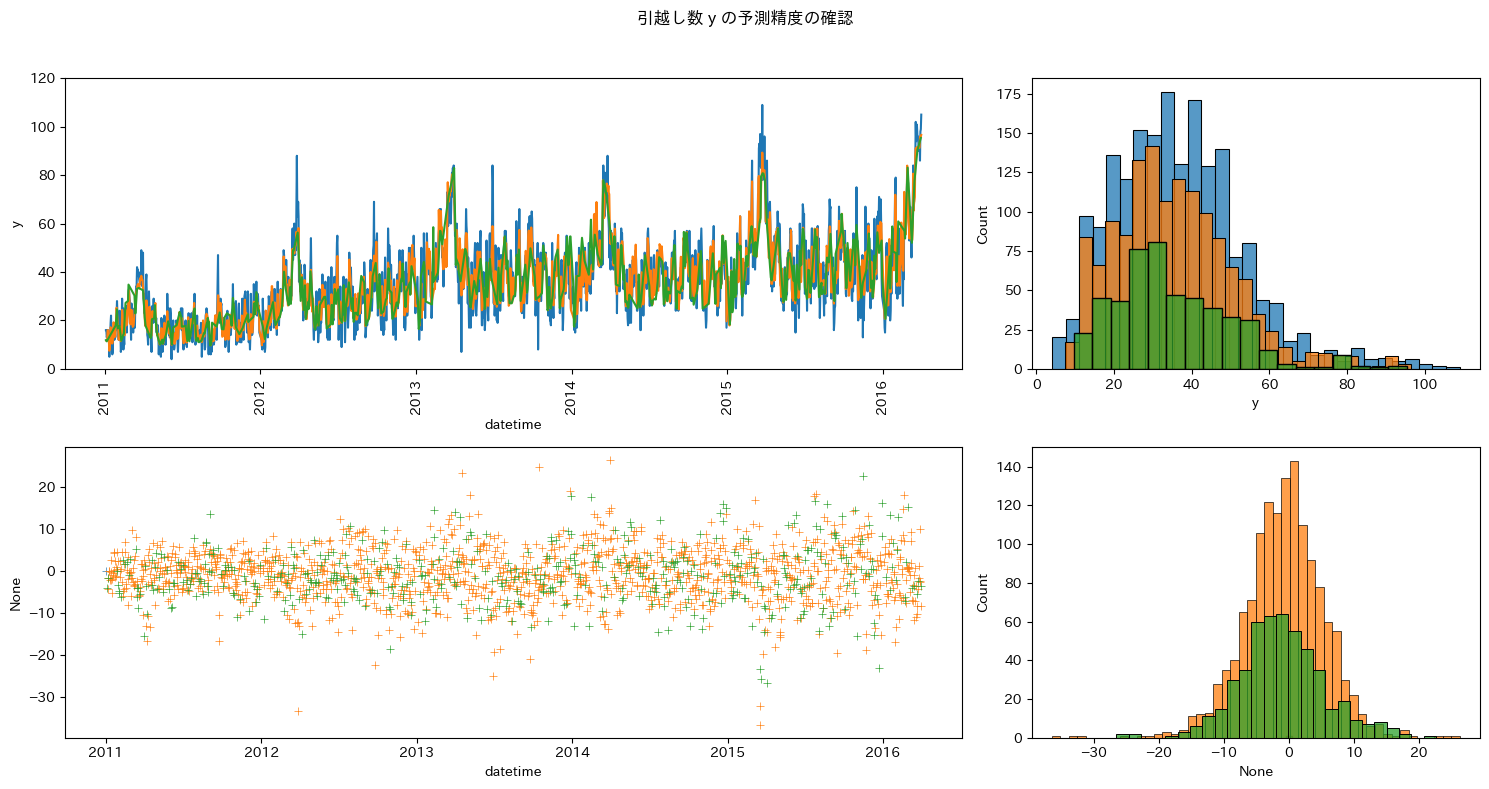

[Text(0.5, 1.0, '特徴量の重要度')]

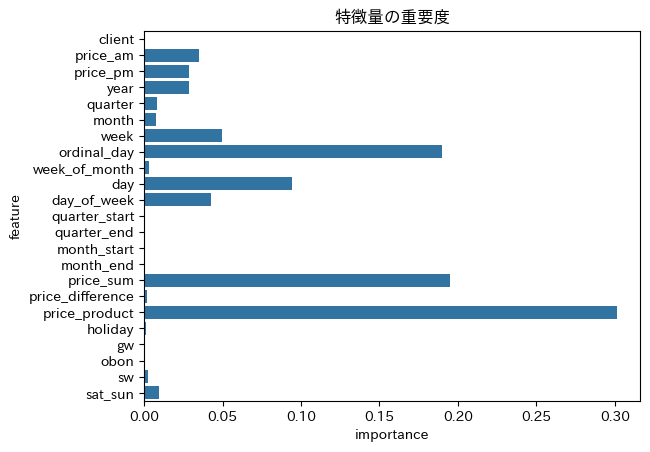

In [39]:
# 学習
est = GradientBoostingRegressor(random_state = 1192).fit(X_train, y_train)

# 予測(対数変換を逆変換する)
y_pred_train = np.exp(est.predict(X_train) + train_temp["y_prophet"])
y_pred_valid = np.exp(est.predict(X_valid) + valid_temp["y_prophet"])


# 予測精度の確認
print("訓練データの評価関数:", np.round(mean_absolute_error(train_temp["y"], y_pred_train), decimals = 7))# 小数第7位はコンペスコアの有効数字
print("評価データの評価関数:", np.round(mean_absolute_error(valid_temp["y"], y_pred_valid), decimals = 7))

# 予測結果の確認
fig, axes = plt.subplots(
    nrows = 2, ncols = 2, # axの縦・横の数
    height_ratios = [1, 1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 8)
)

# 描画
g_time_train = sns.lineplot(data = train, x = "datetime", y = "y", ax = axes[0, 0])
g_predict_train = sns.lineplot(x = train_temp["datetime"], y = y_pred_train, ax = axes[0, 0])
g_predict_valid = sns.lineplot(x = valid_temp["datetime"], y = y_pred_valid, ax = axes[0, 0])

g_hist_train = sns.histplot(data = train, x = "y", ax = axes[0, 1])
g_predict_hist_train = sns.histplot(x = y_pred_train, ax = axes[0, 1])
g_predict_hist_valid = sns.histplot(x = y_pred_valid, ax = axes[0, 1])

# 残差
g_residual_dummy = sns.scatterplot(x = [date(2011, 1, 1)], y = 0, marker = "+", ax = axes[1, 0])
g_residual_train = sns.scatterplot(x = train_temp["datetime"], y = y_pred_train - train_temp["y"], marker = "+", ax = axes[1, 0])
g_residual_valid = sns.scatterplot(x = valid_temp["datetime"], y = y_pred_valid - valid_temp["y"], marker = "+", ax = axes[1, 0])

g_residual_hist_dummy = sns.histplot(x = [0], ax = axes[1, 1])
g_residual_hist_train = sns.histplot(x = y_pred_train - train_temp["y"], ax = axes[1, 1])
g_residual_hist_valid = sns.histplot(x = y_pred_valid - valid_temp["y"], ax = axes[1, 1])


# 調整
plt.setp(g_time_train.get_xticklabels(), rotation = 90)
plt.setp(g_time_train, ylim = (0, 120))

plt.suptitle("引越し数 y の予測精度の確認")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

# 特徴量の重要度
df_feature_importance = pl.DataFrame({
    "feature": est.feature_names_in_,
    "importance": est.feature_importances_
})
g_importance = sns.barplot(data = df_feature_importance, x = "importance", y = "feature")
plt.setp(g_importance, title = "特徴量の重要度")

In [40]:
# Pandasに変換
train_busy_pandas = train.filter( (pl.col("datetime").dt.month() == 3) | (pl.col("datetime").dt.month() == 4) ).to_pandas().set_index("id")
train_other_pandas = train.filter( ~((pl.col("datetime").dt.month() == 3) | (pl.col("datetime").dt.month() == 4)) ).to_pandas().set_index("id")

# 目的変数と特徴量
target_column = "y_difference"
feature_columns = ['client', 'price_am', 'price_pm',
                    'year', 'quarter', 'month', 'week', 'ordinal_day', 'week_of_month', 'day', 'day_of_week',
                    'quarter_start', 'quarter_end', 'month_start', 'month_end',
                    'price_sum', 'price_difference', 'price_product',
                    'holiday', 'gw', 'obon', 'sw', 'sat_sun'
 ]

# 訓練データと評価データに分割するマスク
np.random.seed(1192)
train_mask_busy_1 = np.random.choice([True, False], size = len(train_busy_pandas), p = [0.75, 0.25])
train_mask_other_1 = np.random.choice([True, False], size = len(train_other_pandas), p = [0.75, 0.25])


# 説明変数、目的変数の分割
train_busy_temp, valid_busy_temp = train_busy_pandas[train_mask_busy_1], train_busy_pandas[~train_mask_busy_1]
X_train_busy, y_train_busy = train_busy_temp[feature_columns], train_busy_temp[target_column]
X_valid_busy, y_valid_busy = valid_busy_temp[feature_columns], valid_busy_temp[target_column]

train_other_temp, valid_other_temp = train_other_pandas[train_mask_other_1], train_other_pandas[~train_mask_other_1]
X_train_other, y_train_other = train_other_temp[feature_columns], train_other_temp[target_column]
X_valid_other, y_valid_other = valid_other_temp[feature_columns], valid_other_temp[target_column]

繁忙期の訓練データの評価関数: 5.5641985
繁忙期の評価データの評価関数: 5.8779229
その他の時期の訓練データの評価関数: 4.7336484
その他の時期の評価データの評価関数: 4.5305894


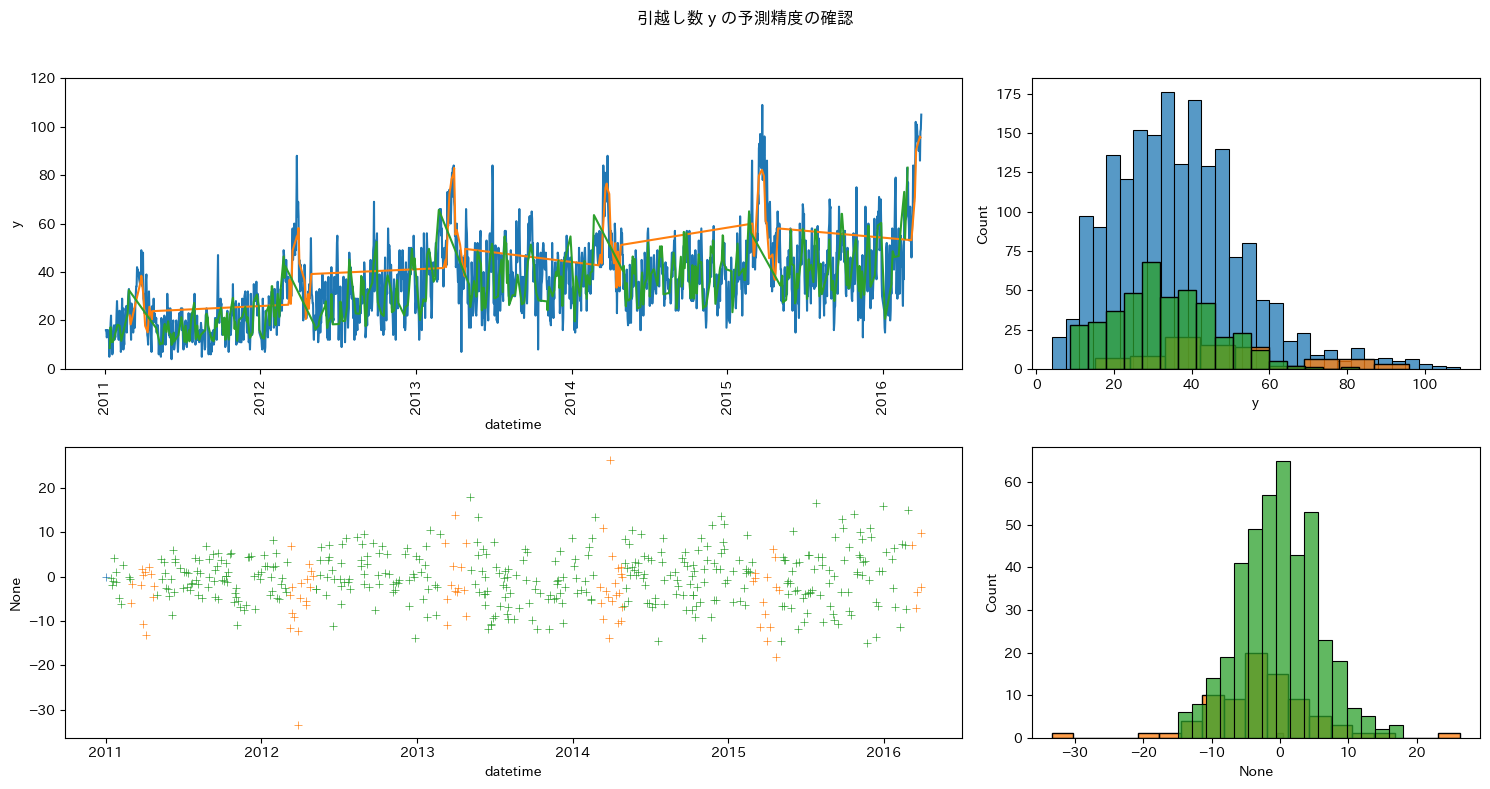

[Text(0.5, 1.0, '特徴量の重要度')]

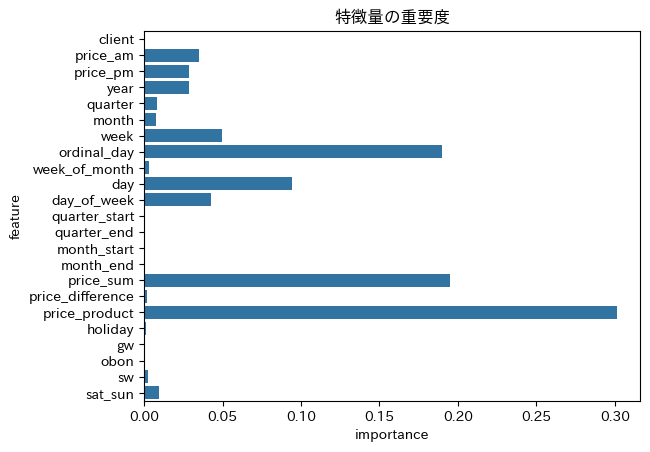

In [41]:
# 学習
est_busy = GradientBoostingRegressor(random_state = 1192).fit(X_train_busy, y_train_busy)
est_other = GradientBoostingRegressor(random_state = 1192).fit(X_train_other, y_train_other)


# 予測(対数変換を逆変換する)
y_pred_train_busy = np.exp(est.predict(X_train_busy) + train_busy_temp["y_prophet"])
y_pred_valid_busy = np.exp(est.predict(X_valid_busy) + valid_busy_temp["y_prophet"])

y_pred_train_other = np.exp(est.predict(X_train_other) + train_other_temp["y_prophet"])
y_pred_valid_other = np.exp(est.predict(X_valid_other) + valid_other_temp["y_prophet"])


# 予測精度の確認
# 小数第7位はコンペスコアの有効数字
print("繁忙期の訓練データの評価関数:", np.round(mean_absolute_error(train_busy_temp["y"], y_pred_train_busy), decimals = 7))
print("繁忙期の評価データの評価関数:", np.round(mean_absolute_error(valid_busy_temp["y"], y_pred_valid_busy), decimals = 7))
print("その他の時期の訓練データの評価関数:", np.round(mean_absolute_error(train_other_temp["y"], y_pred_train_other), decimals = 7))
print("その他の時期の評価データの評価関数:", np.round(mean_absolute_error(valid_other_temp["y"], y_pred_valid_other), decimals = 7))



# 予測結果の確認
fig, axes = plt.subplots(
    nrows = 2, ncols = 2, # axの縦・横の数
    height_ratios = [1, 1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 8)
)

# 描画
g_time_train = sns.lineplot(data = train, x = "datetime", y = "y", ax = axes[0, 0])
#g_predict_train_busy = sns.lineplot(x = train_busy_temp["datetime"], y = y_pred_train_busy, ax = axes[0, 0])
g_predict_valid_busy = sns.lineplot(x = valid_busy_temp["datetime"], y = y_pred_valid_busy, ax = axes[0, 0])

#g_predict_train_other = sns.lineplot(x = train_other_temp["datetime"], y = y_pred_train_other, ax = axes[0, 0])
g_predict_valid_other = sns.lineplot(x = valid_other_temp["datetime"], y = y_pred_valid_other, ax = axes[0, 0])


g_hist_train = sns.histplot(data = train, x = "y", ax = axes[0, 1])
#g_predict_hist_train_busy = sns.histplot(x = y_pred_train_busy, ax = axes[0, 1])
g_predict_hist_valid_busy = sns.histplot(x = y_pred_valid_busy, ax = axes[0, 1])
#g_predict_hist_train_other = sns.histplot(x = y_pred_train_other, ax = axes[0, 1])
g_predict_hist_valid_other = sns.histplot(x = y_pred_valid_other, ax = axes[0, 1])


# 残差
g_residual_dummy = sns.scatterplot(x = [date(2011, 1, 1)], y = 0, marker = "+", ax = axes[1, 0])
#g_residual_train_busy = sns.scatterplot(x = train_busy_temp["datetime"], y = y_pred_train_busy - train_busy_temp["y"], marker = "+", ax = axes[1, 0])
g_residual_valid_busy = sns.scatterplot(x = valid_busy_temp["datetime"], y = y_pred_valid_busy - valid_busy_temp["y"], marker = "+", ax = axes[1, 0])
#g_residual_train_other = sns.scatterplot(x = train_other_temp["datetime"], y = y_pred_train_other - train_other_temp["y"], marker = "+", ax = axes[1, 0])
g_residual_valid_other = sns.scatterplot(x = valid_other_temp["datetime"], y = y_pred_valid_other - valid_other_temp["y"], marker = "+", ax = axes[1, 0])

g_residual_hist_dummy = sns.histplot(x = [0], ax = axes[1, 1])
#g_residual_hist_train_busy = sns.histplot(x = y_pred_train_busy - train_busy_temp["y"], ax = axes[1, 1])
g_residual_hist_valid_busy = sns.histplot(x = y_pred_valid_busy - valid_busy_temp["y"], ax = axes[1, 1])
#g_residual_hist_train_other = sns.histplot(x = y_pred_train_other - train_other_temp["y"], ax = axes[1, 1])
g_residual_hist_valid_other = sns.histplot(x = y_pred_valid_other - valid_other_temp["y"], ax = axes[1, 1])

# 調整
plt.setp(g_time_train.get_xticklabels(), rotation = 90)
plt.setp(g_time_train, ylim = (0, 120))

plt.suptitle("引越し数 y の予測精度の確認")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

# 特徴量の重要度
df_feature_importance = pl.DataFrame({
    "feature": est.feature_names_in_,
    "importance": est.feature_importances_
})
g_importance = sns.barplot(data = df_feature_importance, x = "importance", y = "feature")
plt.setp(g_importance, title = "特徴量の重要度")

In [42]:
# 機械学習ライブラリと親和性の高いPandasに変換する
train_pandas = train.to_pandas().set_index("id")

# 目的変数と特徴量
target_column = "y_difference"
feature_columns = [
    #'client',
    'price_am', 'price_pm',
    'year', 'quarter', 'month', 'week', 'ordinal_day', 'week_of_month', 'day', 'day_of_week',
    #'quarter_start', 'quarter_end', 'month_start', 'month_end',
    'price_sum', 'price_difference', 'price_product',
    'holiday',
    #'gw', 'obon',
    'sw', 'sat_sun'
 ]

# 訓練データと評価データに分割するマスク
np.random.seed(1192)
train_mask_1 = np.random.choice([True, False], size = len(train_pandas), p = [0.75, 0.25])

# 説明変数、目的変数の分割
train_temp, valid_temp = train_pandas[train_mask_1], train_pandas[~train_mask_1]
X_train, y_train = train_temp[feature_columns], train_temp[target_column]
X_valid, y_valid = valid_temp[feature_columns], valid_temp[target_column]

訓練データの評価関数: 4.7395114
評価データの評価関数: 5.1839395


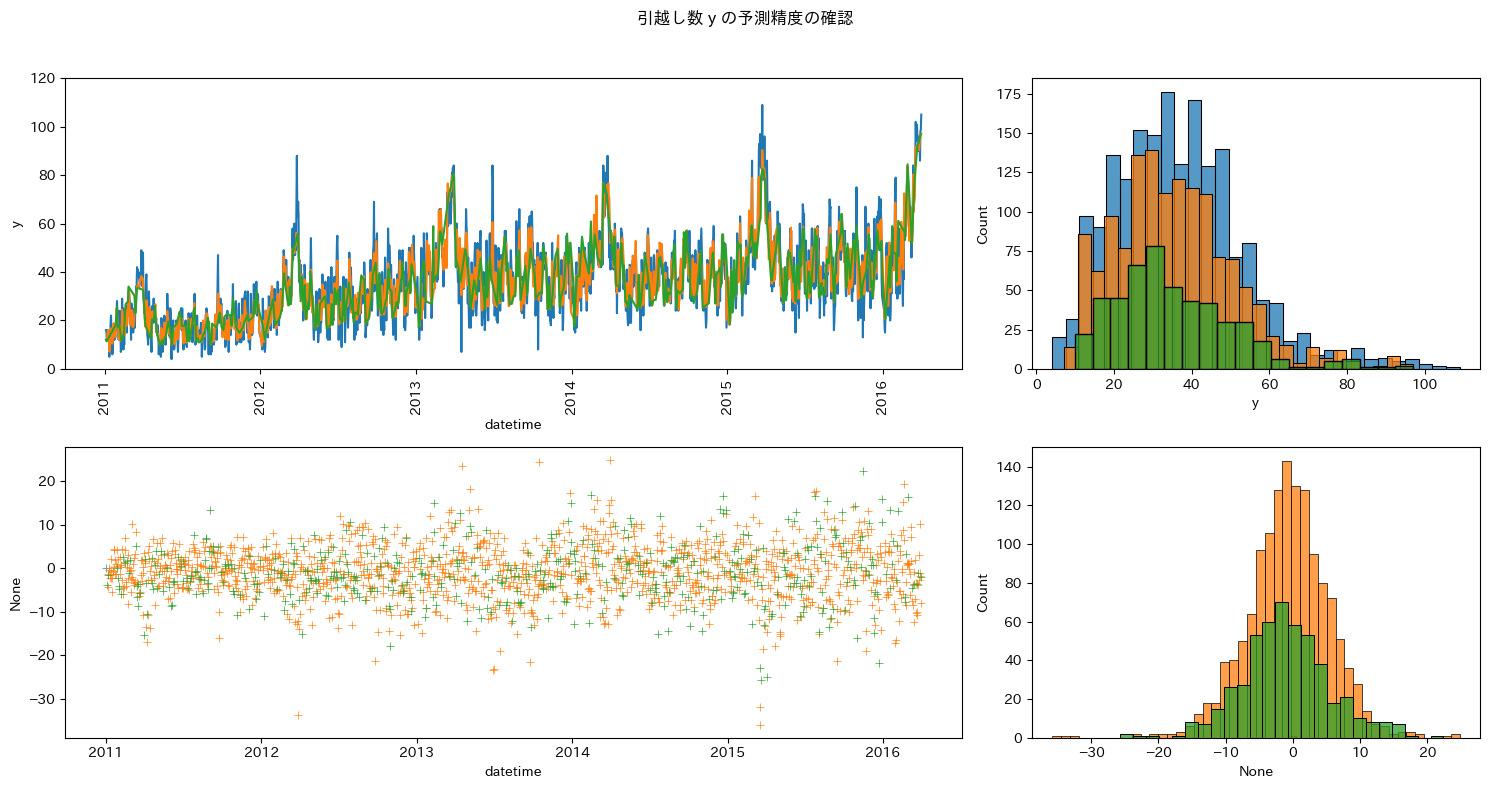

[Text(0.5, 1.0, '特徴量の重要度')]

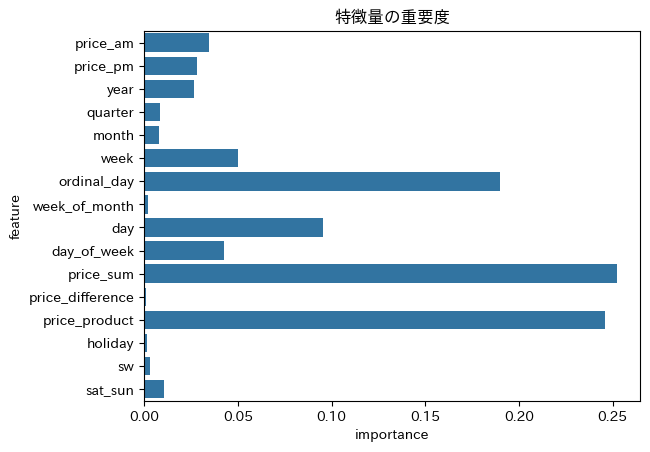

In [43]:
# 学習
est = GradientBoostingRegressor(random_state = 1192).fit(X_train, y_train)

# 予測(対数変換を逆変換する)
y_pred_train = np.exp(est.predict(X_train) + train_temp["y_prophet"])
y_pred_valid = np.exp(est.predict(X_valid) + valid_temp["y_prophet"])


# 予測精度の確認
print("訓練データの評価関数:", np.round(mean_absolute_error(train_temp["y"], y_pred_train), decimals = 7))# 小数第7位はコンペスコアの有効数字
print("評価データの評価関数:", np.round(mean_absolute_error(valid_temp["y"], y_pred_valid), decimals = 7))

# 予測結果の確認
fig, axes = plt.subplots(
    nrows = 2, ncols = 2, # axの縦・横の数
    height_ratios = [1, 1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 8)
)

# 描画
g_time_train = sns.lineplot(data = train, x = "datetime", y = "y", ax = axes[0, 0])
g_predict_train = sns.lineplot(x = train_temp["datetime"], y = y_pred_train, ax = axes[0, 0])
g_predict_valid = sns.lineplot(x = valid_temp["datetime"], y = y_pred_valid, ax = axes[0, 0])

g_hist_train = sns.histplot(data = train, x = "y", ax = axes[0, 1])
g_predict_hist_train = sns.histplot(x = y_pred_train, ax = axes[0, 1])
g_predict_hist_valid = sns.histplot(x = y_pred_valid, ax = axes[0, 1])

# 残差
g_residual_dummy = sns.scatterplot(x = [date(2011, 1, 1)], y = 0, marker = "+", ax = axes[1, 0])
g_residual_train = sns.scatterplot(x = train_temp["datetime"], y = y_pred_train - train_temp["y"], marker = "+", ax = axes[1, 0])
g_residual_valid = sns.scatterplot(x = valid_temp["datetime"], y = y_pred_valid - valid_temp["y"], marker = "+", ax = axes[1, 0])

g_residual_hist_dummy = sns.histplot(x = [0], ax = axes[1, 1])
g_residual_hist_train = sns.histplot(x = y_pred_train - train_temp["y"], ax = axes[1, 1])
g_residual_hist_valid = sns.histplot(x = y_pred_valid - valid_temp["y"], ax = axes[1, 1])


# 調整
plt.setp(g_time_train.get_xticklabels(), rotation = 90)
plt.setp(g_time_train, ylim = (0, 120))

plt.suptitle("引越し数 y の予測精度の確認")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

# 特徴量の重要度
df_feature_importance = pl.DataFrame({
    "feature": est.feature_names_in_,
    "importance": est.feature_importances_
})
g_importance = sns.barplot(data = df_feature_importance, x = "importance", y = "feature")
plt.setp(g_importance, title = "特徴量の重要度")

In [44]:
# 機械学習ライブラリと親和性の高いPandasに変換する
train_pandas = train.to_pandas().set_index("id")

# 目的変数と特徴量
target_column = "y_difference"
feature_columns = [
    #'client',
    'price_am', 'price_pm',
    'year', 'quarter', 'month', 'week', 'ordinal_day', 'week_of_month', 'day', 'day_of_week',
    #'quarter_start', 'quarter_end', 'month_start', 'month_end',
    'price_sum', 'price_difference', 'price_product',
    'holiday',
    #'gw', 'obon',
    'sw', 'sat_sun'
 ]

# 訓練データと評価データに分割するマスク
np.random.seed(1192)
train_mask_1 = np.random.choice([True, False], size = len(train_pandas), p = [0.75, 0.25])

# 説明変数、目的変数の分割
train_temp, valid_temp = train_pandas[train_mask_1], train_pandas[~train_mask_1]
X_train, y_train = train_temp[feature_columns], train_temp[target_column]
X_valid, y_valid = valid_temp[feature_columns], valid_temp[target_column]

最適ハイパーパラメータ {'validation_fraction': np.float64(0.14444444444444446), 'subsample': np.float64(1.0), 'random_state': 346, 'n_estimators': np.int64(165), 'min_weight_fraction_leaf': np.float64(0.125), 'min_samples_split': np.int64(50), 'max_features': None, 'max_depth': np.int64(10), 'loss': 'absolute_error', 'learning_rate': np.float64(0.15000000000000002), 'criterion': 'friedman_mse'}
訓練データの評価関数: 5.0100863
評価データの評価関数: 5.2525763


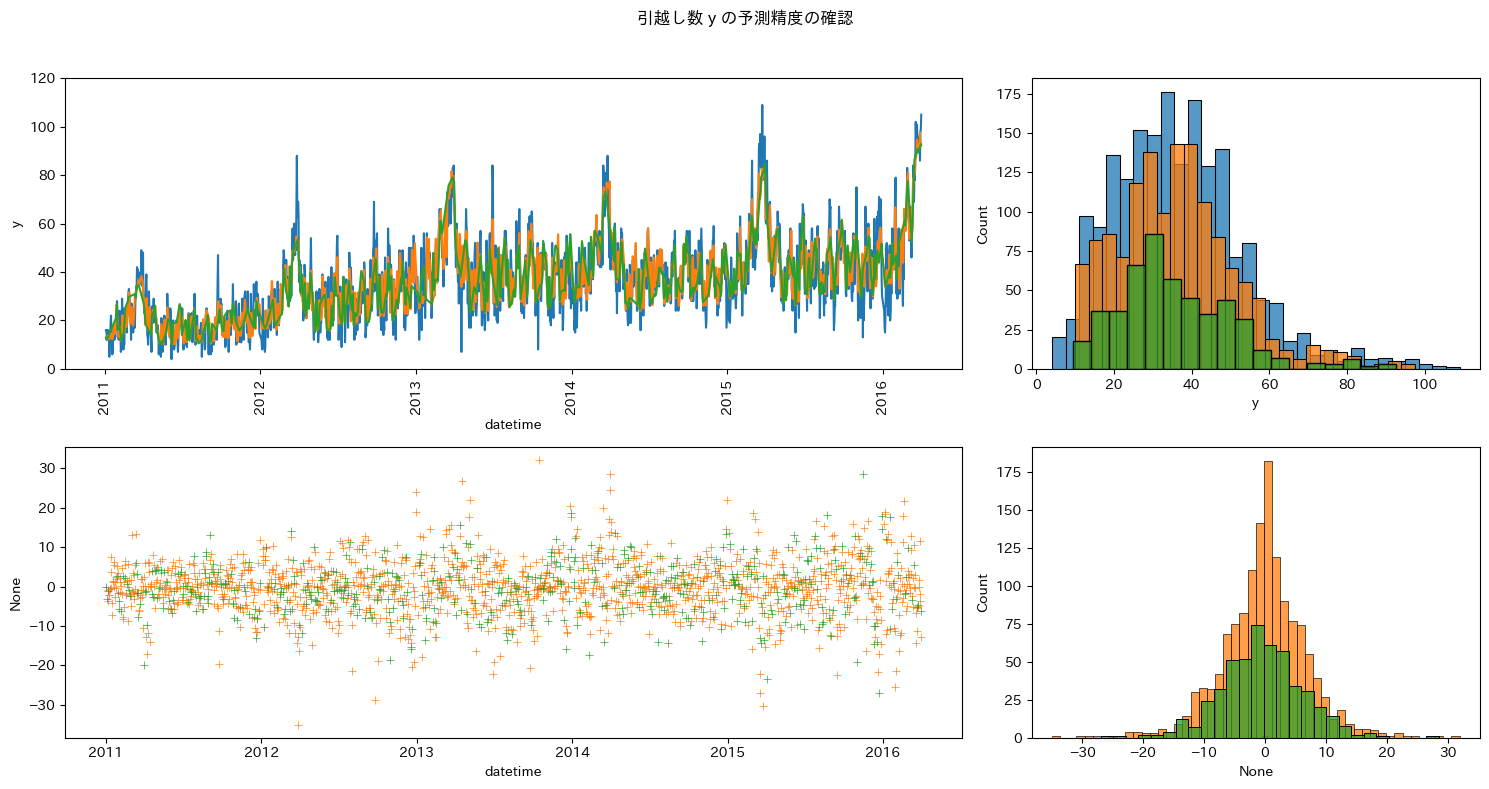

In [45]:
# ハイパーパラメータ最適化時の評価関数
scoring = make_scorer(r2_score, response_method = "predict", greater_is_better = True)

# 推定器
est = GradientBoostingRegressor()

# 交差検証器
rkf = RepeatedKFold(n_splits = 4, n_repeats = 20, random_state = 1192)

# ハイパーパラメータ
param_distributions = {
    "loss": ["squared_error", "absolute_error", "huber"],
    "learning_rate": np.linspace(0.1, 0.2, num = 5, endpoint = True, dtype = float),
    "n_estimators": np.linspace(10, 255, num = 100, endpoint = True, dtype = int),
    "subsample": np.linspace(0.5, 1, num = 10, endpoint = True, dtype = float),
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": np.linspace(2, 50, num = 10, endpoint = True, dtype = int),
    "min_weight_fraction_leaf": np.linspace(0, 0.5, num = 5, endpoint = True, dtype = float),
    "max_depth": np.linspace(1, 20, num = 5, endpoint = True, dtype = int),
    "max_features": ["sqrt", "log2", None],
    "validation_fraction": np.linspace(0.1, 0.5, num = 10, endpoint = True, dtype = float),
    "random_state": [1192, 765, 961, 876, 346, 315, 283],
}

# 最終推定器
search = HalvingRandomSearchCV(
    est,
    param_distributions = param_distributions,
    cv = rkf,
    scoring = scoring,
    return_train_score = True,
    random_state = 0
    ).fit(X_train, y_train)
print("最適ハイパーパラメータ", search.best_params_)


# 予測(対数変換を逆変換する)
y_pred_train = np.exp(search.predict(X_train) + train_temp["y_prophet"])
y_pred_valid = np.exp(search.predict(X_valid) + valid_temp["y_prophet"])


# 予測精度の確認
print("訓練データの評価関数:", np.round(mean_absolute_error(train_temp["y"], y_pred_train), decimals = 7))# 小数第7位はコンペスコアの有効数字
print("評価データの評価関数:", np.round(mean_absolute_error(valid_temp["y"], y_pred_valid), decimals = 7))

# 予測結果の確認
fig, axes = plt.subplots(
    nrows = 2, ncols = 2, # axの縦・横の数
    height_ratios = [1, 1], width_ratios = [2, 1], # ax の縦・横比
    figsize = (15, 8)
)

# 描画
g_time_train = sns.lineplot(data = train, x = "datetime", y = "y", ax = axes[0, 0])
g_predict_train = sns.lineplot(x = train_temp["datetime"], y = y_pred_train, ax = axes[0, 0])
g_predict_valid = sns.lineplot(x = valid_temp["datetime"], y = y_pred_valid, ax = axes[0, 0])

g_hist_train = sns.histplot(data = train, x = "y", ax = axes[0, 1])
g_predict_hist_train = sns.histplot(x = y_pred_train, ax = axes[0, 1])
g_predict_hist_valid = sns.histplot(x = y_pred_valid, ax = axes[0, 1])

# 残差
g_residual_dummy = sns.scatterplot(x = [date(2011, 1, 1)], y = 0, marker = "+", ax = axes[1, 0])
g_residual_train = sns.scatterplot(x = train_temp["datetime"], y = y_pred_train - train_temp["y"], marker = "+", ax = axes[1, 0])
g_residual_valid = sns.scatterplot(x = valid_temp["datetime"], y = y_pred_valid - valid_temp["y"], marker = "+", ax = axes[1, 0])

g_residual_hist_dummy = sns.histplot(x = [0], ax = axes[1, 1])
g_residual_hist_train = sns.histplot(x = y_pred_train - train_temp["y"], ax = axes[1, 1])
g_residual_hist_valid = sns.histplot(x = y_pred_valid - valid_temp["y"], ax = axes[1, 1])


# 調整
plt.setp(g_time_train.get_xticklabels(), rotation = 90)
plt.setp(g_time_train, ylim = (0, 120))

plt.suptitle("引越し数 y の予測精度の確認")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整
plt.show()

# 特徴量の重要度
#df_feature_importance = pl.DataFrame({
#    "feature": est.feature_names_in_,
#    "importance": est.feature_importances_
#})
#g_importance = sns.barplot(data = df_feature_importance, x = "importance", y = "feature")
#plt.setp(g_importance, title = "特徴量の重要度")

In [46]:
# 機械学習ライブラリと親和性の高いPandasに変換する
test_pandas = test.to_pandas().set_index("id")

# 説明変数の分割
X_test = test_pandas[feature_columns]

# 予測(対数変換を逆変換する)
y_pred_train = np.exp(search.predict(X_test) + test_pandas["y_prophet"])

# 提出DataFrame
submit = pl.DataFrame({
    "id": X_test.index.values,
    "y": y_pred_train.values,
})
# close = 1 のデータと連結する
submit = pl.concat(
    [submit, test_close],
    how = "vertical_relaxed"
).sort("id")

# 提出ファイルを保存する
submit.write_csv(f"{path}submit.csv", include_header = False)

In [47]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu May 15 2025

Python implementation: CPython
Python version       : 3.11.12
IPython version      : 7.34.0

japanize_matplotlib: 1.1.3
sklearn            : 1.6.1
jpholiday          : 1.0.2
google             : 2.0.3
numpy              : 2.0.2
prophet            : 1.1.6
polars             : 1.21.0
seaborn            : 0.13.2
matplotlib         : 3.10.0

Watermark: 2.5.0

